# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to 20 years, and the timescale of mesoscale eddies the Hawaiian Island archipelago are 3 - 6 months. It's important to keep in mind that in this analysis we are not directly relating any of these processes to the observed sea levels at the tide gauges, but rather we are looking at _variability on similar timescales_. 

Thus, we're breaking sea level down into:

$\eta = \eta_{tide} + \eta_{t_N} + \eta_{NTR}$

where

$\eta_{NTR} = \eta_{D} + \eta_{S} + \eta_{ItA} + \eta_{InA} + \eta_{W} + \eta_{HF}$

Note that $\eta_{tide}$ here is accounting for the nodal cycle modulation, and thus it is absent from the non-tidal residuals.

<!-- # make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 8-30+ yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'} -->


```{caution}
THIS IS STILL BEING UPDATED. USE with Caution.
```

## Setup

In [233]:
print('Importing libraries')
%run setup.ipynb
print('Importing plotting rules and functions')
import plotting_functions
print('Importing time series functions')
from tseries_functions import *
from tide_functions import calculate_ntr

Importing libraries
Importing plotting rules and functions
Importing time series functions


## Obtain the Non-tidal Residual (NTR)

First we'll estimate the astronomical tides at this location using the selected epoch. The tide values are estimated using the python implementation of UTide (pypi.org/project/utide, based off Codiga 2011).

The routine is as follows:
 - Detrend the hourly sea level data for 2002-2020 epoch 
 - Solve for coefficents with no nodal corrections using the detrended data
 - Solve for coefficients with nodal corrections using the detrended data
 - Reconstruct the full timeseries based on:
    - all coefficients (including nodal, annual, and semi-annual cycles)
    - all coefficients except the nodal cycle
    - all coefficients except the annual and semi-annual cycles

Here, we define the NTR as:

$ NTR = SL - T - LT $,

where SL is the sea level, T is the predicted tide (including nodal, annual and semi-annual) and LT is the linear trend.

The nodal modulation is the difference between the tidal predictions with and without the nodal corrections applied.

In [234]:
ds = xr.open_dataset(data_dir / 'rsl_pacific.nc')



# get the ntr for each station
calculate_ntr(ds)

Already processed 36 files:
[1612480, 25, 1617760, 1612340, 1617433, 38, 1617433, 25, 1612340, 1611400, 1617760, 1611400, 1615680, 1611400, 1612480, 1617760, 38, 1612480, 38, 25, 38, 1615680, 1619910, 1619910, 1612340, 1615680, 1615680, 1619910, 1617760, 1619910, 1617433, 25, 1611400, 1617433, 1612480, 1612340]


In [235]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:               (station_id: 2, time: 307803)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 1990-06-20T21:00:00 ... 2...
  * station_id            (station_id) int64 16B 25 38
Data variables: (12/13)
    sea_level             (station_id, time) float32 2MB ...
    lat                   (station_id) float32 8B ...
    lon                   (station_id) float32 8B ...
    station_name          (station_id) <U10 80B ...
    station_country       (station_id) <U6 48B ...
    station_country_code  (station_id) float32 8B ...
    ...                    ...
    gloss_id              (station_id) float32 8B ...
    ssc_id                (station_id) <U4 32B ...
    last_rq_date          (station_id) datetime64[ns] 16B ...
    MHHW                  (station_id) float64 16B ...
    MSL                   (station_id) float64 16B ...
    MLLW                  (station_id) float64 16B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-09-19T14:45:21Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [236]:
# # use IPCC 1995-2014 as epoch
station = 25  #<---Change this to select different stations
epoch_start = np.datetime64('1996-01-01') #<---Following what I believe Phil used??
epoch_end = np.datetime64('2014-12-31')

diff_time = epoch_end - epoch_start
print('Epoch length (years):', diff_time / np.timedelta64(1, 'D') / 365.25)

mid_time = epoch_start + diff_time/2
print('Epoch mid time:', mid_time)

mhhw = ds.sel(station_id=station, time=slice(epoch_start, epoch_end)).sea_level.resample(time='1490min').max().mean().item()
mhhw
msl = ds.sel(station_id=station, time=slice(epoch_start, epoch_end)).sea_level.mean().item()
msl, mhhw, station

Epoch length (years): 18.99794661190965
Epoch mid time: 2005-07-01


(2015.50439453125, 2707.275634765625, 25)

In [237]:
# load ntr data
station = 38
print('Doing station', station)
station_name = ds.station_name.sel(station_id=station).item()
print('Station name:', station_name)
# mhhw = ds.MHHW.sel(station_id=station).item()
# mllw = ds.MLLW.sel(station_id=station).item()
# msl = ds.MSL.sel(station_id=station).item()
ntrpath = f'ntr_data/ntr_{station:03d}.csv'




ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 38
Station name: Nuku'alofa


time         ntr   ntr_noASA  sea_level  \
0      1990-06-20 21:00:00  143.956763  111.854563      570.0   
1      1990-06-20 22:00:00  177.380975  145.258362      400.0   
2      1990-06-20 23:00:00  148.746909  116.603899      310.0   
3      1990-06-21 00:00:00  148.901945  116.738555      410.0   
4      1990-06-21 01:00:00  128.183924   96.000169      630.0   
...                    ...         ...         ...        ...   
307798 2025-07-31 19:00:00  -84.458320 -128.754693      665.0   
307799 2025-07-31 20:00:00 -101.800440 -146.101347      774.0   
307800 2025-07-31 21:00:00  -80.975979 -125.281403      976.0   
307801 2025-07-31 22:00:00  -93.341502 -137.651428     1154.0   
307802 2025-07-31 23:00:00  -69.882393 -114.196803     1324.0   

        sea_level_detrended        trend        tide      nodal  \
0               -336.826945   906.826945 -480.783708  10.439206   
1               -506.827768   906.827768 -684.208743   0.618843   
2               -596.828591   906.828591 -745.575500  -8.449450   
3               -496.829414   906.829414 -645.731359 -13.284231   
4               -276.830238   906.830238 -405.014161 -11.023748   
...                     ...          ...         ...        ...   
307798          -495.164926  1160.164926 -410.706605  -9.743810   
307799          -386.165749  1160.165749 -284.365309  -4.428355   
307800          -184.166572  1160.166572 -103.190593   3.749482   
307801            -6.167395  1160.167395   87.174108  13.180628   
307802           163.831782  1160.168218  233.714175  20.987799   

        ntr_withNodal  seasonal_cycle  
0          133.517557      -31.781387  
1          176.762131      -31.801800  
2          157.196359      -31.822197  
3          162.186176      -31.842577  
4          139.207672      -31.862942  
...               ...             ...  
307798     -74.714511      -43.975560  
307799     -97.372085      -43.980094  
307800     -84.725461      -43.984612  
307801    -106.522130      -43.989113  
307802     -90.870192      -43.993597  

[307803 rows x 10 columns]

In the above dataframe, 'ntr_noASA' is the NTR if the Annual and Semi-Annual cycles are also removed, such that:

$ NTR = SL - T - LT - ASA $,

where SL is the sea level, T is the predicted tide (including nodal, annual and semi-annual), LT is the linear trend, and ASA is the combined Annual and Semi-Annual cycle.

### Take a first look at the data

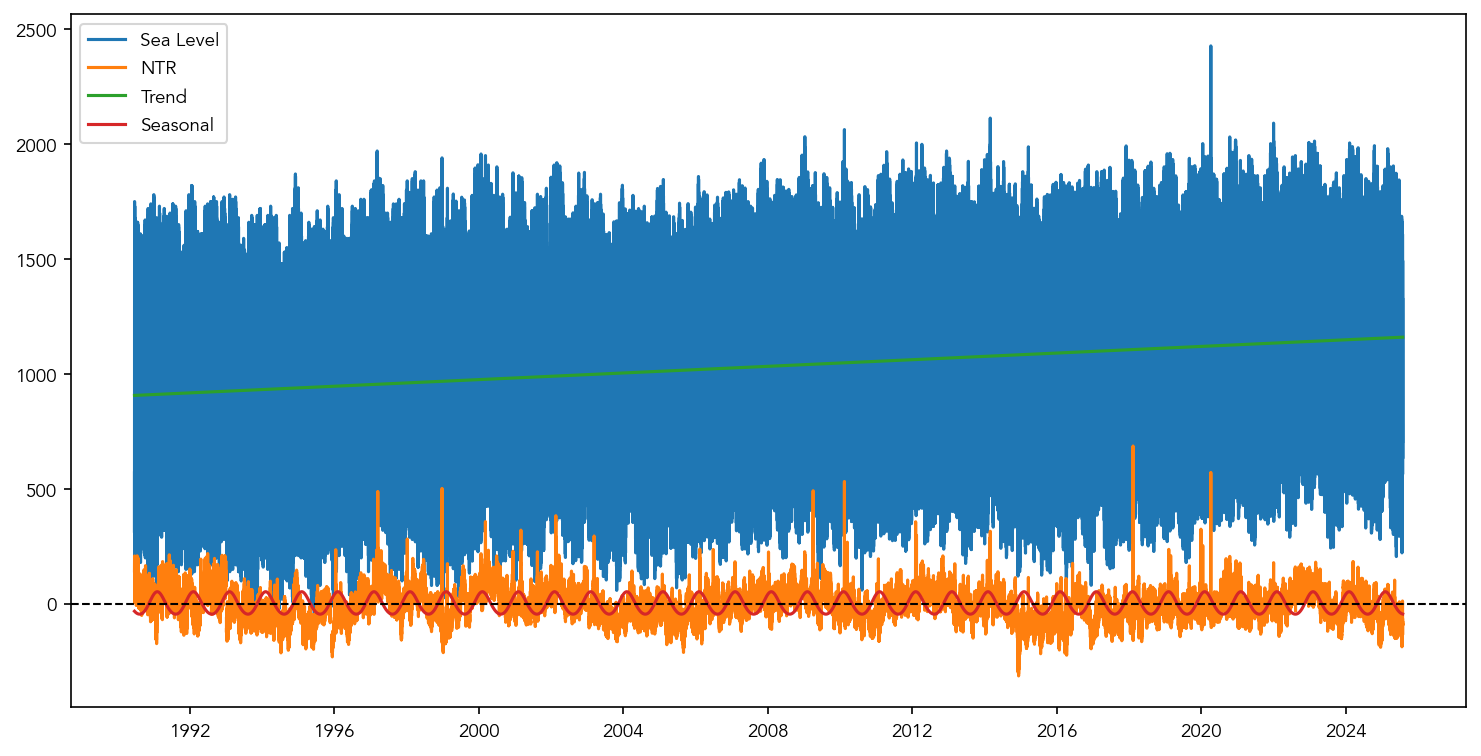

In [238]:
#plot sea level
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ntr_data.time, ntr_data.sea_level, label='Sea Level')
ax.plot(ntr_data.time, ntr_data.ntr , label='NTR')
ax.plot(ntr_data.time, ntr_data.trend, label='Trend')
ax.plot(ntr_data.time, ntr_data.seasonal_cycle, label='Seasonal')

# add zero line
ax.axhline(0, color='k', linestyle='--', lw=1)

# add legend
ax.legend()

Do a quick check to make sure that the tide + NTR is the same as the detrended sea level.

(np.float64(16801.0), np.float64(16852.0))

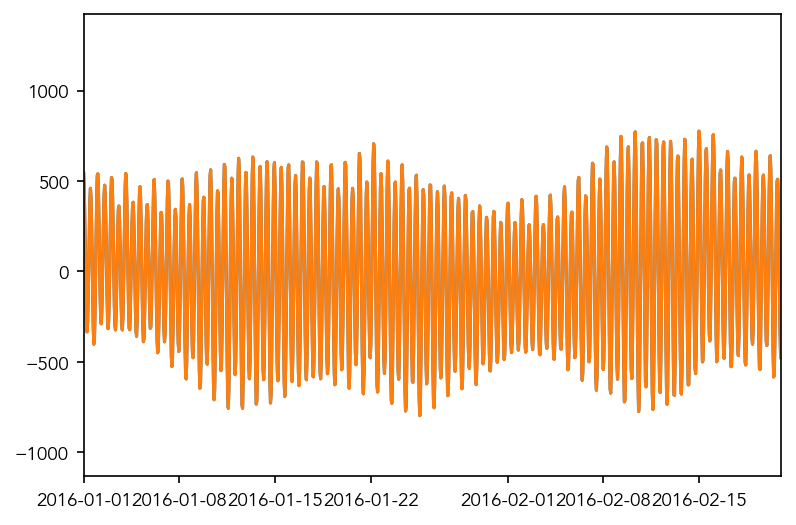

In [239]:
plt.plot(ntr_data['time'], ntr_data.tide + ntr_data.ntr, label='Tide+NTR')
plt.plot(ntr_data['time'], ntr_data.sea_level_detrended, label='Sea Level')
#truncate x axis to 2016 only
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-2-21'))

### Plot and Inspect
We're looking at the NTR with and without the nodal modulation removed.

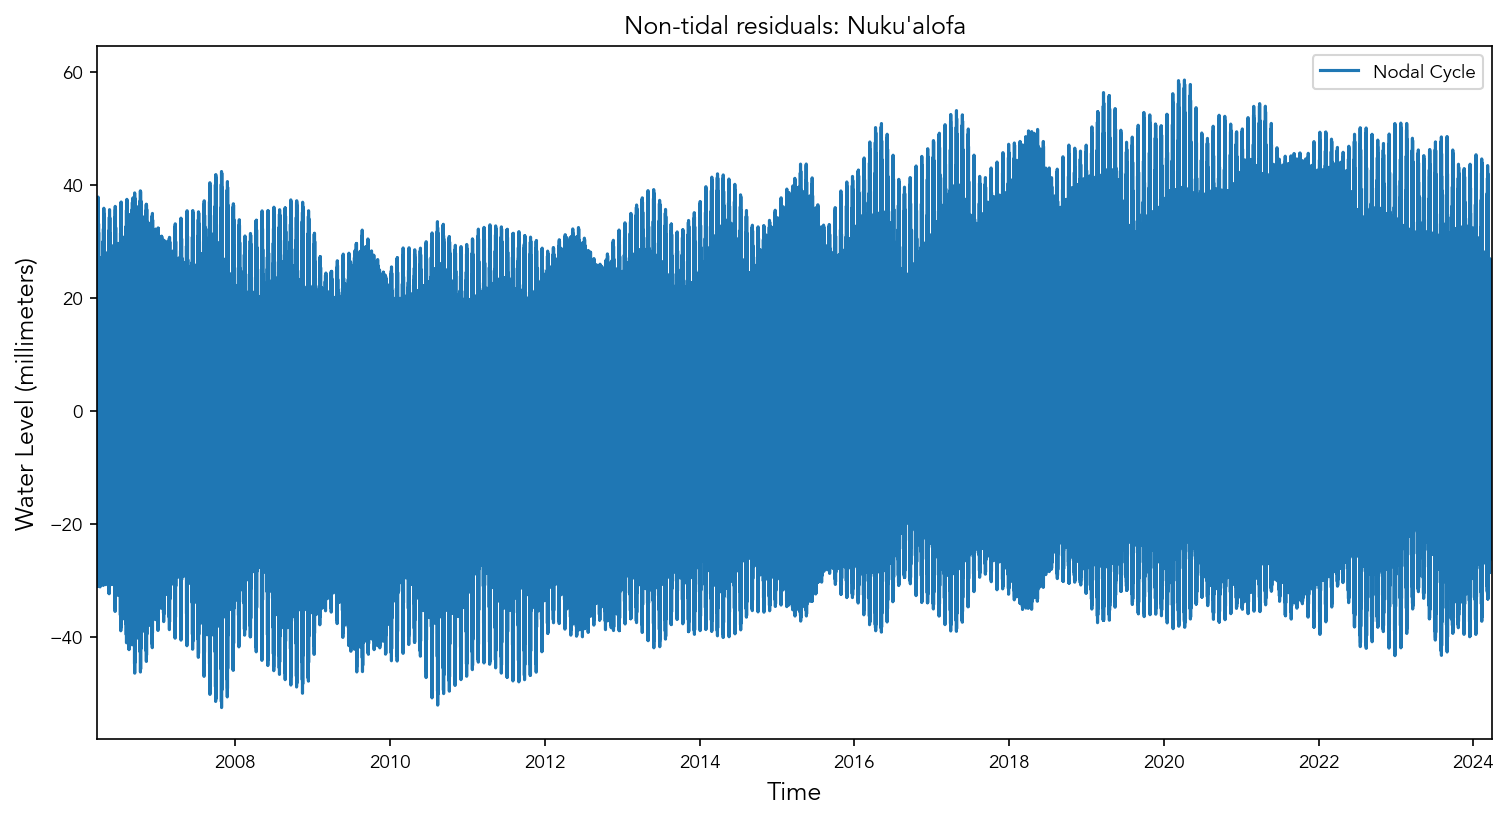

In [240]:
#plot time series
plt.figure(figsize=(12, 6))
# plt.plot(ntr_data['time'], ntr_data['ntr_withNodal'], label='NTR, nodal cycle not accounted for')
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
# plt.plot(ntr_data['time'], ntr_data['tide'], label='Predicted Tide')

# plt.plot(ntr_data['time'], ntr_data['ntr'] , label='Nodal modulated signal (NTR with nodal cycle - NTR without nodal cycle)')

plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle')

# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Water Level' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2006-03-21'), np.datetime64('2024-03-30')])
plt.legend()


## First, let's see if there's a seasonal cycle
We'll do this by fitting an annual and semi-annual cycle to day-of-year data.

(0.0, 366.0)

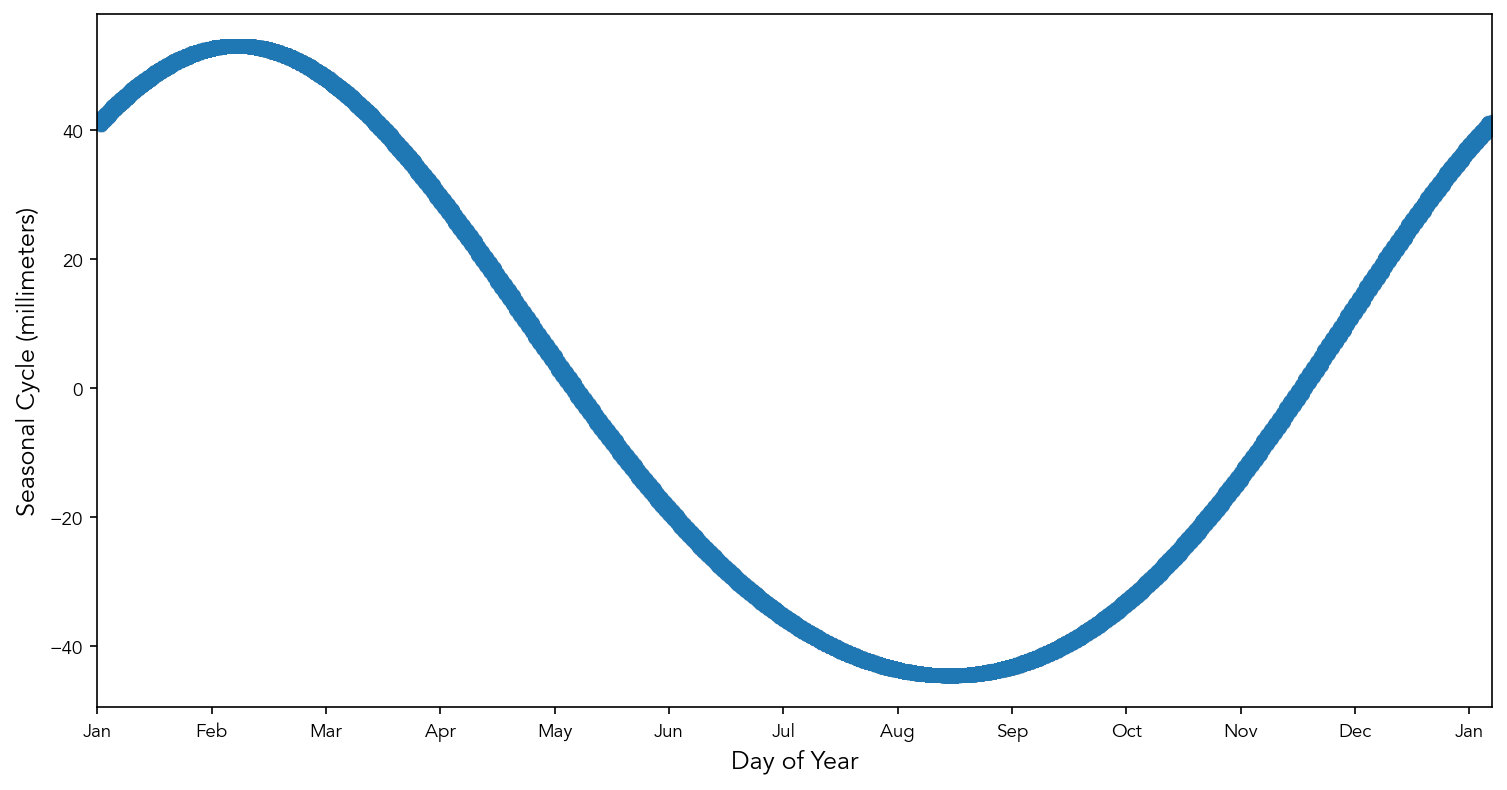

In [241]:
# Step 1, look at the Annual and Semi-annual cycles from UTide
#convert timeseries to day of year
ntr_data['dayofyear'] = ntr_data['time'].dt.dayofyear
#plot time series with day of year
plt.figure(figsize=(12, 6))
plt.scatter(ntr_data['dayofyear'], ntr_data['seasonal_cycle'], label='NTR with Nodal Cycle', alpha=0.05)

# change x-axis to be months
plt.xticks(np.arange(0, 365, 30), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan'])
plt.xlabel('Day of Year')
plt.ylabel('Seasonal Cycle' + ' (' + ds['sea_level'].attrs['units'] + ')')
plt.xlim(0, 366)

Next, compare the a fitted seasonal cycle (sinusoid) to the UTide Annual and Semi-Annual cycle.

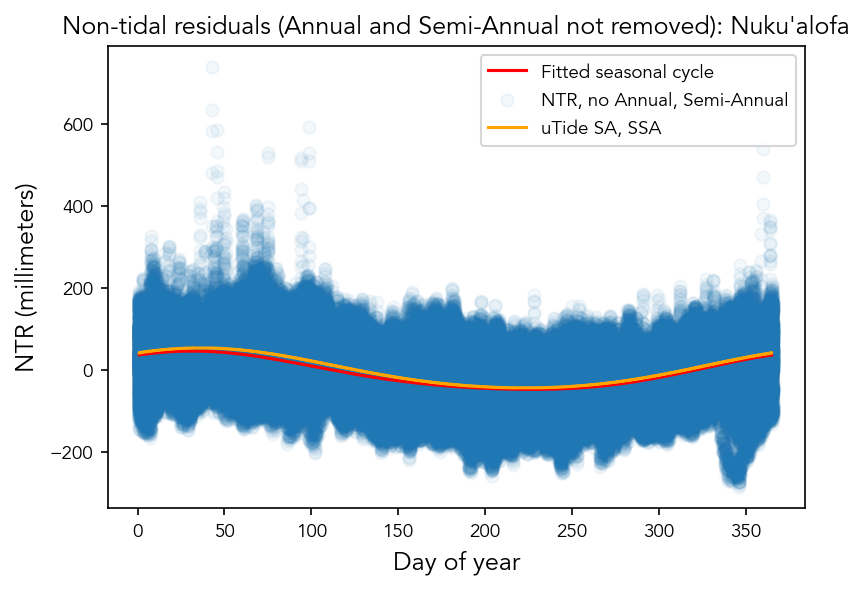

In [242]:
# Fit an annual and semi-annual cycle to the data
from scipy.optimize import curve_fit
from scipy.optimize import minimize
def seasonal_cycle(x, a, b, c, d, e):
    return a * np.sin(2 * np.pi * (x - b) / 365.25) + c * np.sin(2 * np.pi * (x - d) / 182.25) + e


# Remove rows with NaN values in 'ntr' or 'dayofyear'
filtered_data = ntr_data.dropna(subset=['ntr_noASA', 'dayofyear'])

# Fit the seasonal cycle to the filtered data
# Define a function to minimize the absolute deviation (median fitting)
def median_loss(params, x, y):
    return np.sum(np.abs(y - seasonal_cycle(x, *params)))

# Initial guess for the parameters
initial_guess = [1, 1, 1, 1, 1]

# Perform the minimization
result = minimize(median_loss, initial_guess, args=(filtered_data['dayofyear'], filtered_data['ntr_noASA']))

# Extract the optimized parameters
popt = result.x

# Plot the fitted seasonal cycle
x = np.linspace(1, 365, 1000)
plt.plot(x, seasonal_cycle(x, *popt), color='red', label='Fitted seasonal cycle')
plt.scatter(ntr_data['dayofyear'], ntr_data['ntr_noASA'], label='NTR, no Annual, Semi-Annual', alpha=0.05)

mask = pd.to_datetime(ntr_data['time']).dt.year == 1995
plt.plot(ntr_data['dayofyear'][mask], ntr_data['seasonal_cycle'][mask], label='uTide SA, SSA', color='orange')
plt.title('Non-tidal residuals (Annual and Semi-Annual not removed): ' + station_name)
plt.xlabel('Day of year')
plt.ylabel('NTR' + ' (' + ds['sea_level'].attrs['units'] + ')')

# add legend
plt.legend()

In [243]:
#standard deviation of the seasonal cycle
seasonal_cycle_std = np.std(seasonal_cycle(filtered_data['dayofyear'], *popt))
print('Standard deviation of the seasonal cycle:', seasonal_cycle_std)

Standard deviation of the seasonal cycle: 33.169648424415556


Text(0, 0.5, 'NTR (millimeters)')

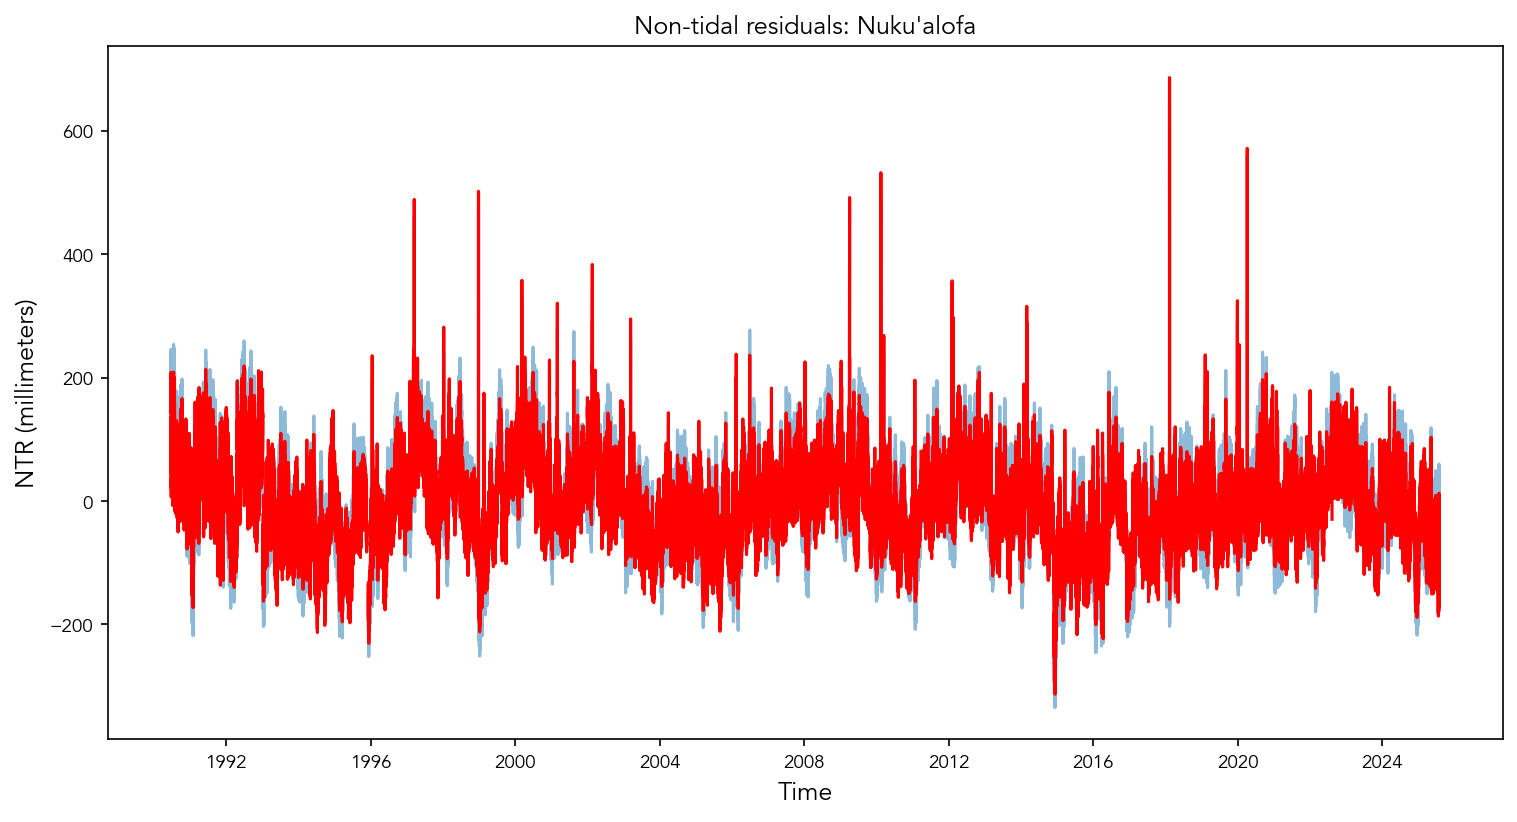

In [244]:
# Generate the full seasonal cycle in the original time domain
ntr_data['seasonal_cycle'] = seasonal_cycle(ntr_data['dayofyear'], *popt)
# Plot the original data and the fitted seasonal cycle
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr']-ntr_data['seasonal_cycle'], label='NTR, Seasonal cycle removed', alpha=0.5)
plt.plot(ntr_data['time'], ntr_data['ntr'], color='red', label='NTR')
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('NTR' + ' (' + ds['sea_level'].attrs['units'] + ')')

### Let's examine the Nodal modulation a bit more
As noted by others studying the Honolulu tide gauge (e.g. Thompson et al), the modulation of the nodal cycle on the 99th percentile water levels can affect high sea levels by up to 5cm. In low-lying areas this contribution can be significant. Here, we'll simulate this effect by taking the upper envelope of the yearly max of the nodal modulation. 

In [245]:
# # Let's try treating the nodal cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.

nodal = ntr_data['nodal'].copy()
nodal = nodal - nodal.mean()  # remove the mean
# set index to time
nodal.index = ntr_data['time']

# Calculate rolling max
rolling_max = nodal.rolling('60D', min_periods=1).max()

# Use 99.9th and 0.1th percentiles for yearly max/min
nodal_max = rolling_max.resample('YS').quantile(0.999)
nodal_min = rolling_max.resample('YS').quantile(0.001)
nodal_max_real_date = rolling_max.groupby(rolling_max.index.to_period('Y')).idxmax()
nodal_max.index = pd.to_datetime(nodal_max_real_date.values)


def n_sine(t, A, phase, offset):
    omega = 2 * np.pi / 18.61
    return offset + A * np.sin(omega * t + phase )



def skewed_sine(t, A, phase, skew, offset):
    omega = 2 * np.pi / 18.61
    return offset + A * np.sin(omega * t + phase + skew * np.sin(omega * t + phase))

from scipy.optimize import curve_fit


def get_mod_envelope(tide, fit_times, eval_times):
    """
    Fit the double sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew, offset]
    p0 = [np.std(tide.values), 0, np.mean(tide.values)]

    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(n_sine, t_fit_float, tide.values, p0=p0)

    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = n_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

# Fit the upper envelope
ncyc_upper = get_mod_envelope(nodal_max, nodal_max.index, nodal.index)
# Fit the lower envelop
ncyc_lower = get_mod_envelope(nodal_min, nodal_min.index, nodal.index)

ncyc_mod_upper = np.max(ncyc_upper) - np.min(ncyc_upper)
ncyc_mod_lower = np.max(ncyc_lower) - np.min(ncyc_lower)

print('Nodal cycle amplitude:', str(round(ncyc_mod_upper*0.1, 2)) , 'cm')


Nodal cycle amplitude: 2.24 cm


In [246]:
# # Let's try fitting  cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years or 4.4 for perigean tides.
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.


tide = ntr_data['tide'].copy()
tide = tide + ntr_data['nodal']  # add the nodal cycle back
# tide = tide - ntr_data['seasonal_cycle']  # Keep seasonal in there.
tide.index = ntr_data['time']
#exclude 1993 and 2025
# tide = tide[(tide.index.year != 1993) & (tide.index.year != 2025)]
tide = tide - tide.mean()  # remove the mean
# set index to time


# Calculate rolling max
rolling_max = tide.rolling('60D', min_periods=1).max()
monthly_max = rolling_max.resample('MS').max()
monthly_min = rolling_max.resample('MS').min()
monthly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('M')).idxmax()
monthly_max.index = pd.to_datetime(monthly_max_real_date.values)

# Use 99.9th and 0.1th percentiles for yearly max/min
yearly_max = rolling_max.resample('YS').quantile(0.999)
yearly_min = rolling_max.resample('YS').quantile(0.001)
yearly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('Y')).idxmax()
yearly_max.index = pd.to_datetime(yearly_max_real_date.values)

def perigee_double_sine(t, A1, phase1, A2, phase2, offset):
    omega1 = 2 * np.pi / 4.425
    omega2 = 2 * np.pi / 8.85
    return (offset
            + A1 * np.sin(omega1 * t + phase1 )
            + A2 * np.sin(omega2 * t + phase2 ))

def perigee_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 4.425
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))

def nodal_skewed_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))


def nodal_sine(t, A1, phase1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 ))

from scipy.optimize import curve_fit


def get_mod_envelope_double(tide, fit_times, eval_times):
    """
    Fit the double sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(perigee_double_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = perigee_double_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

def get_mod_envelope_nodal(tide, fit_times, eval_times):
    """
    Fit the nodal sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    # p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]
    p0 = [np.std(tide.values), 0, np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(nodal_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = nodal_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

# Fit the upper envelope with both cycles
pcyc_upper_double = get_mod_envelope_double(yearly_max, yearly_max.index, ntr_data['time'].values)
pcyc_lower_double = get_mod_envelope_double(yearly_min, yearly_min.index, ntr_data['time'].values)

# Amplitudes
pcyc_mod_upper_double = np.max(pcyc_upper_double) - np.min(pcyc_upper_double)
pcyc_mod_lower_double = np.max(pcyc_lower_double) - np.min(pcyc_lower_double)


# Fit the upper envelope with both cycles
nodal_upper = get_mod_envelope_nodal(yearly_max, yearly_max.index, ntr_data['time'].values)
nodal_lower = get_mod_envelope_nodal(yearly_min, yearly_min.index, ntr_data['time'].values)

# Amplitudes
nodal_upper_amp = np.max(nodal_upper) - np.min(nodal_upper)
nodal_lower_amp = np.max(nodal_lower) - np.min(nodal_lower)

print('Lunar Perigean cycle amplitude:', str(round(pcyc_mod_upper_double*0.1, 2)), 'cm')
print('Nodal cycle amplitude:', str(round(nodal_upper_amp*0.1, 2)), 'cm')


Lunar Perigean cycle amplitude: 3.3 cm
Nodal cycle amplitude: 0.22 cm


Text(0, 0.5, 'Predicted Water Level (cm)')

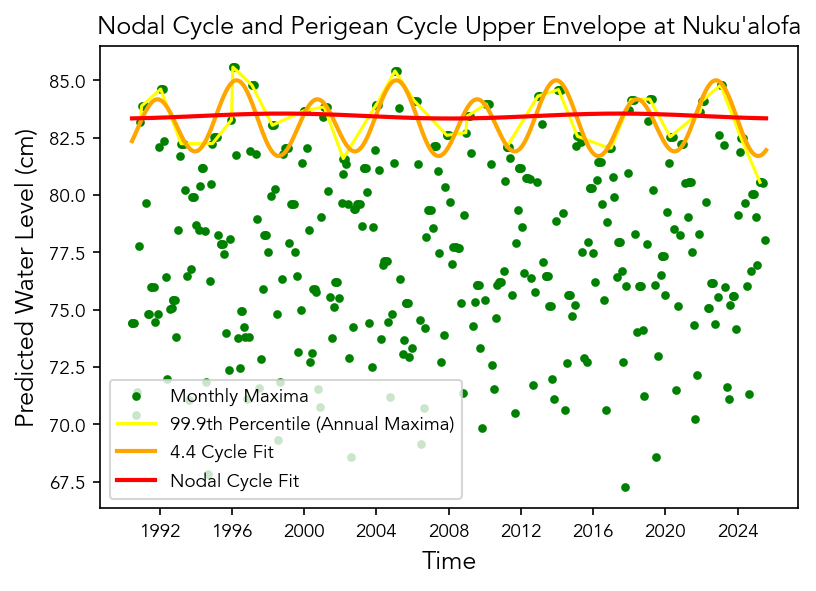

In [247]:
plt.scatter(monthly_max_real_date,0.1*monthly_max, label='Monthly Maxima', color='green',s=10)
plt.plot(yearly_max.index,0.1*yearly_max, label='99.9th Percentile (Annual Maxima)', color='yellow')
# plt.scatter(nodal_upper_envelope.index,0.1*nodal_upper_envelope, label='Nodal Cycle Upper Envelope Monthly', color='magenta',s=3)
# plt.scatter(nodal_upper_envelope1.index,0.1*nodal_upper_envelope1, label='Nodal Cycle Upper Envelope Monthly', color='yellow',s=3)


plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double), label='4.4 Cycle Fit', color='orange', lw=2)
plt.plot(nodal_upper.index, 0.1*(nodal_upper), label='Nodal Cycle Fit', color='red', lw=2)
# plt.plot(ncyc_upper.index, 0.1*(nodal_upper-nodal_upper.mean()+pcyc_upper_double), label='18.61y+4.425y+8.85y', color='blue', lw=2)
# add legend
plt.legend()

# add title
plt.title('Nodal Cycle and Perigean Cycle Upper Envelope at ' + station_name)
plt.xlabel('Time')
plt.ylabel('Predicted Water Level (cm)')
# interpolate the pyc_upper_double to the nodal cycle upper envelope

#set xlimits to just 2000-2022
# plt.xlim([np.datetime64('2010-01-01'), np.datetime64('2022-12-31')])



In [248]:
#extract top 5 tides
top_tides = ntr_data.nlargest(5, 'tide')
print('Top tides:')
print(top_tides[['time', 'tide']])

Top tides:
                      time        tide
48970  1996-01-21 07:00:00  875.103616
58211  1997-02-09 08:00:00  871.026167
58186  1997-02-08 07:00:00  866.417985
48995  1996-01-22 08:00:00  866.192316
207010 2014-01-31 07:00:00  861.705792


Text(0.5, 1.0, "Nodal and Perigean Cycles: Nuku'alofa")

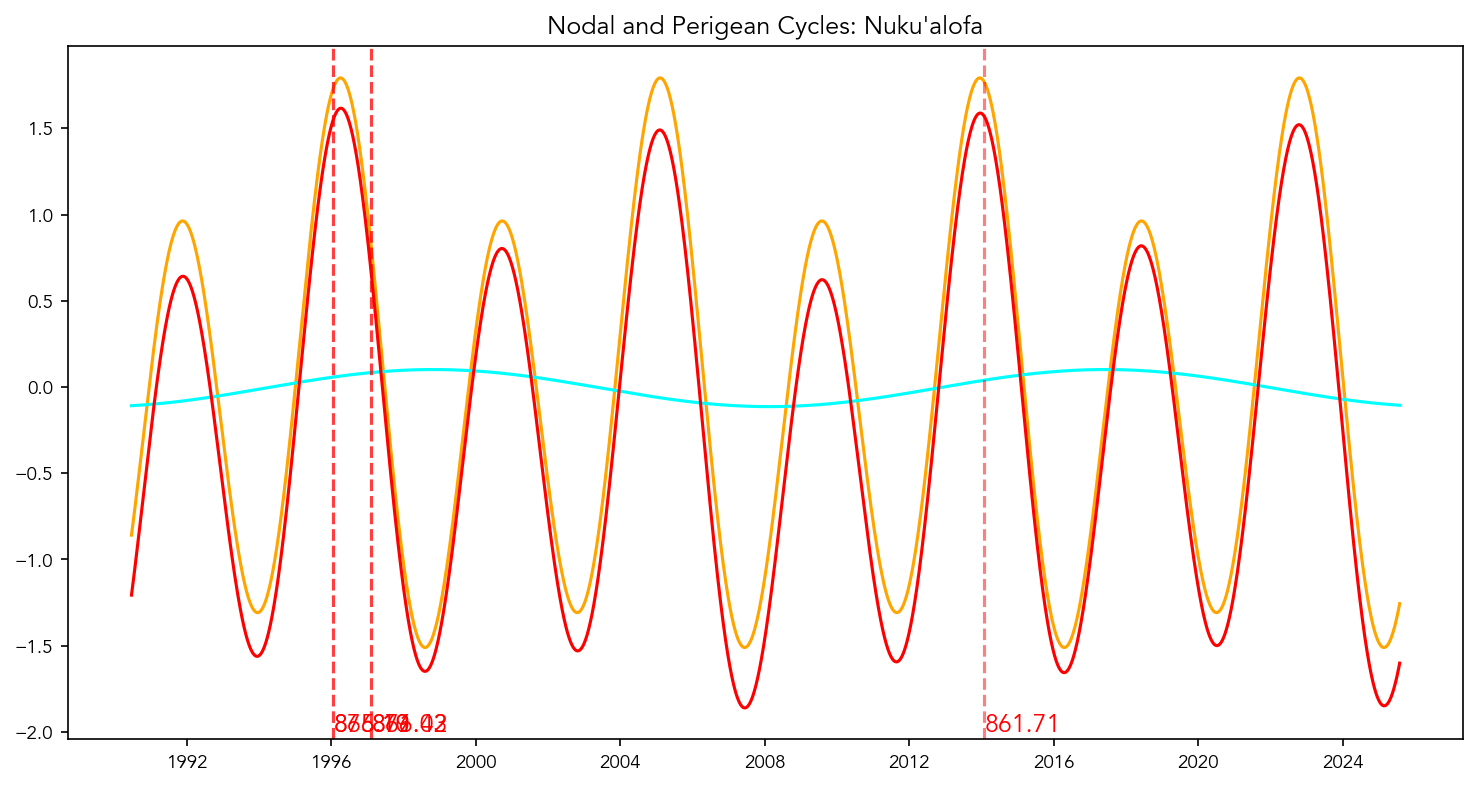

In [249]:
# plot the nodal and perigean cycles
plt.figure(figsize=(12, 6))
# plt.plot(ncyc_upper.index, 0.1*(ncyc_upper-ncyc_upper.mean()), label='Nodal Cycle Upper Envelope', color='blue')
plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-pcyc_upper_double.mean()), label='Perigean Cycle Upper Envelope', color='orange')
# plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-pcyc_upper_double.mean()+ncyc_upper-ncyc_upper.mean()), label='Perigean Cycle Upper Envelope', color='orange')
plt.plot(nodal_upper.index, 0.1*(nodal_upper-nodal_upper.mean()), label='Nodal Cycle Upper Envelope', color='cyan')
plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-nodal_upper.mean()+nodal_upper-nodal_upper.mean()), label='Perigean Cycle Upper Envelope', color='red')
# plt.plot(ptime, 0.1*(ncyc_upper-ncyc_upper.mean()), label='Astronomical Stuff', color='cyan')

#mark the top 5 tides withv ertical lines
for i, row in top_tides.iterrows():
    plt.axvline(row['time'], color='red', linestyle='--', alpha=0.5)
    plt.text(row['time'], -2, f"{row['tide']:.2f}", color='red', fontsize=12)
plt.title('Nodal and Perigean Cycles: ' + station_name)


In [250]:
perigean_cycle = pcyc_upper_double - pcyc_upper_double.mean()

Does the epoch used for analysis matter here? We use 18.6 for the nodal cycle but what if the that's messing up our lunar perigean calculation??

In [251]:
ntr_data

time         ntr   ntr_noASA  sea_level  \
0      1990-06-20 21:00:00  143.956763  111.854563      570.0   
1      1990-06-20 22:00:00  177.380975  145.258362      400.0   
2      1990-06-20 23:00:00  148.746909  116.603899      310.0   
3      1990-06-21 00:00:00  148.901945  116.738555      410.0   
4      1990-06-21 01:00:00  128.183924   96.000169      630.0   
...                    ...         ...         ...        ...   
307798 2025-07-31 19:00:00  -84.458320 -128.754693      665.0   
307799 2025-07-31 20:00:00 -101.800440 -146.101347      774.0   
307800 2025-07-31 21:00:00  -80.975979 -125.281403      976.0   
307801 2025-07-31 22:00:00  -93.341502 -137.651428     1154.0   
307802 2025-07-31 23:00:00  -69.882393 -114.196803     1324.0   

        sea_level_detrended        trend        tide      nodal  \
0               -336.826945   906.826945 -480.783708  10.439206   
1               -506.827768   906.827768 -684.208743   0.618843   
2               -596.828591   906.828591 -745.575500  -8.449450   
3               -496.829414   906.829414 -645.731359 -13.284231   
4               -276.830238   906.830238 -405.014161 -11.023748   
...                     ...          ...         ...        ...   
307798          -495.164926  1160.164926 -410.706605  -9.743810   
307799          -386.165749  1160.165749 -284.365309  -4.428355   
307800          -184.166572  1160.166572 -103.190593   3.749482   
307801            -6.167395  1160.167395   87.174108  13.180628   
307802           163.831782  1160.168218  233.714175  20.987799   

        ntr_withNodal  seasonal_cycle  dayofyear  
0          133.517557      -37.078174        171  
1          176.762131      -37.078174        171  
2          157.196359      -37.078174        171  
3          162.186176      -37.464199        172  
4          139.207672      -37.464199        172  
...               ...             ...        ...  
307798     -74.714511      -47.324892        212  
307799     -97.372085      -47.324892        212  
307800     -84.725461      -47.324892        212  
307801    -106.522130      -47.324892        212  
307802     -90.870192      -47.324892        212  

[307803 rows x 11 columns]

In [252]:
# #plot the nodal signal and the envelope
# plt.figure(figsize=(12, 6))
# plt.plot(ntr_data['time'], 0.1*ntr_data['tide'], label='Predicted Tide',linewidth=0.25)
# plt.plot(ncyc_upper.index, 0.1*ncyc_upper, label='Nodal Upper Modulation Envelope (' + str(round(ncyc_mod_upper*0.1, 2)) + ' cm)', color='red', linewidth=2)
# plt.plot(pcyc_upper_double.index, 0.1*pcyc_upper_double, label='Perigean Upper Modulation Envelope (' + str(round(pcyc_mod_upper_double*0.1, 2)) + ' cm)', color='cyan', linewidth=2)
# # plt.scatter(monthly_max_real_date,0.1*monthly_max, label='Monthly Maxima', color='green',s=3)
# plt.plot(ntr_data['time'], 0.1*ntr_data['seasonal_cycle']+0.1*pcyc_upper_double.mean(), label='Seasonal Cycle', color='purple', linewidth=0.5)
# plt.plot(ncyc_lower.index, 0.1*ncyc_lower, label='Nodal Lower Modulation Envelope (' + str(round(ncyc_mod_lower*0.1, 2)) + ' cm)', color='purple', linewidth=2)
# # plt.scatter(ncyc_lower.index, 0.1*nodal_lower_envelope, label='Yearly 1st percentile', color='cyan', linestyle='-', linewidth=2)

# plt.title('Nodal Cycle: ' + station_name + ' (Based on Yearly 99th percentiles)')

# plt.legend()
# #set x-axis to 2017-2018
# plt.xlim([np.datetime64('1993-01-01'), np.datetime64('2025-03-01')])

(np.float64(8401.0), np.float64(20148.0))

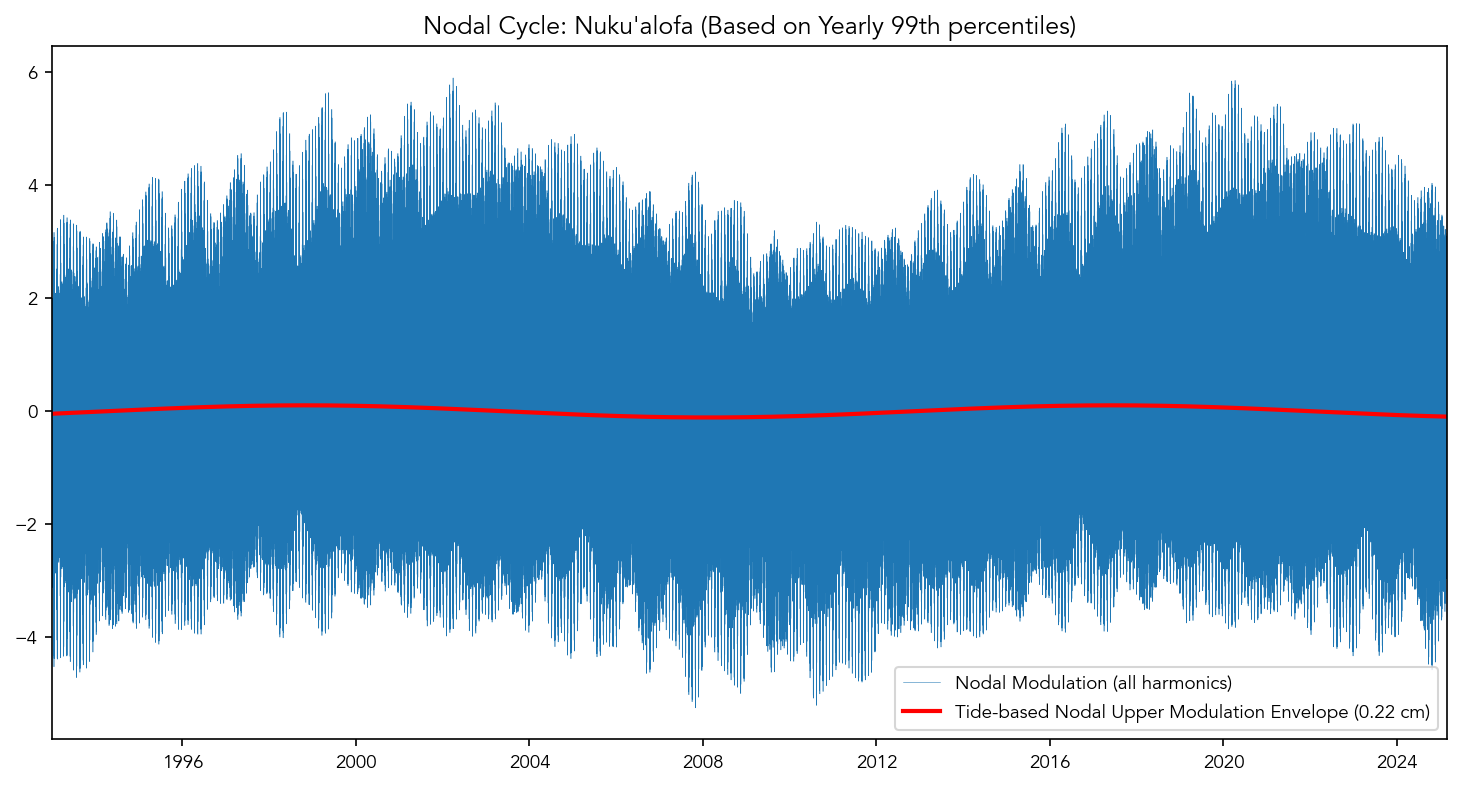

In [253]:
#plot the nodal signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], 0.1*ntr_data['nodal'], label='Nodal Modulation (all harmonics)',linewidth=0.25)
plt.plot(nodal_upper.index, 0.1*(nodal_upper - yearly_max.mean()), label='Tide-based Nodal Upper Modulation Envelope (' + str(round(nodal_upper_amp*0.1, 2)) + ' cm)', color='red', linewidth=2)
# plt.plot(ncyc_upper1.index, 0.1*(ncyc_upper1), label='Nodal-based Nodal Upper Modulation Envelope (' + str(round(ncyc_mod_upper1*0.1, 2)) + ' cm)', color='orange', linewidth=2)


# plt.plot(pcyc_upper.index, 0.1*pcyc_upper, label='Perigean Upper Modulation Envelope (' + str(round(pcyc_mod_upper*0.1, 2)) + ' cm)', color='cyan', linewidth=2)
# plt.scatter(ncyc_upper.index, 0.1*nodal_upper_envelope, label='Yearly 99th percentile', color='orange', linestyle='-', linewidth=2)
# plt.plot(ncyc_lower1.index, 0.1*ncyc_lower1, label='Nodal Lower Modulation Envelope (' + str(round(ncyc_mod_lower*0.1, 2)) + ' cm)', color='purple', linewidth=2)
# plt.scatter(ncyc_lower.index, 0.1*nodal_lower_envelope, label='Yearly 1st percentile', color='cyan', linestyle='-', linewidth=2)

plt.title('Nodal Cycle: ' + station_name + ' (Based on Yearly 99th percentiles)')

plt.legend()
#set x-axis to 2017-2018
plt.xlim([np.datetime64('1993-01-01'), np.datetime64('2025-03-01')])

In [254]:
# ntr_data['time'] = pd.to_datetime(ntr_data['time'])
# ntr_data = ntr_data.set_index('time')
#make subset dataframe of ntr data with just ntr and time
sea_level_data = ntr_data[['ntr','time']].copy()
# sea_level_data['time'] = ntr_data['time']
ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(sea_level_data)
# sea_level_data
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr'] 

In [255]:
ntr_data_mags


{'ntr': np.float64(-23.35661117680318)}

Text(0, 0.5, 'Non-tidal residuals (millimeters)')

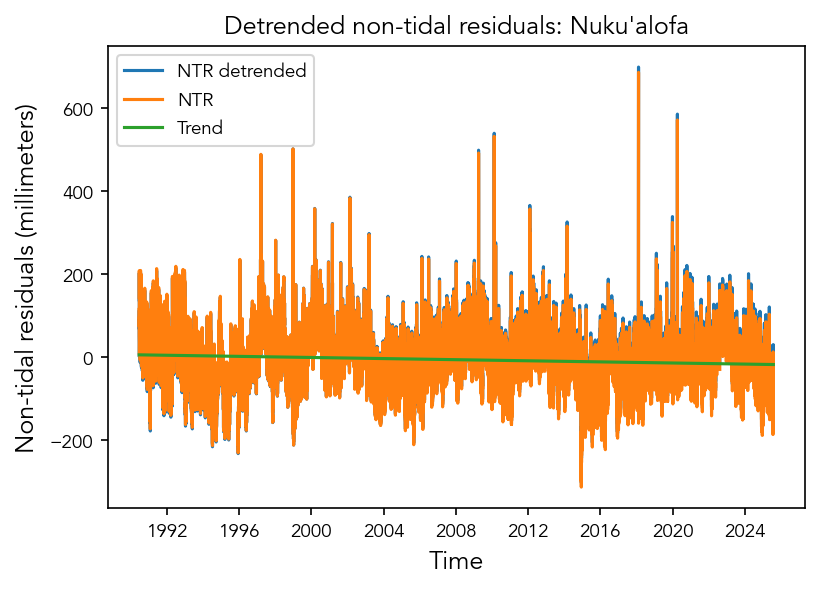

In [256]:
plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR detrended')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2001 Jan to Feb
# plt.xlim([np.datetime64('2017-10-01'), np.datetime64('2017-10-02')])

# set y-axis to -0.1 to 0.1
# plt.ylim([0,200])

In [257]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)
widthSeasonal = 1/365.25/10; #1 cycle per decade



```{caution}
The timescales probably need some refinement. For example: mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

Also:
Firing, Y. L., and M. A. Merrifield (2004), Extreme sea level events at Hawaii: Influence of mesoscale eddies, Geophys. Res. Lett., 31, L24306, doi:10.1029/2004GL021539.

In [258]:
ntr_data

time         ntr   ntr_noASA  sea_level  \
0      1990-06-20 21:00:00  143.956763  111.854563      570.0   
1      1990-06-20 22:00:00  177.380975  145.258362      400.0   
2      1990-06-20 23:00:00  148.746909  116.603899      310.0   
3      1990-06-21 00:00:00  148.901945  116.738555      410.0   
4      1990-06-21 01:00:00  128.183924   96.000169      630.0   
...                    ...         ...         ...        ...   
307798 2025-07-31 19:00:00  -84.458320 -128.754693      665.0   
307799 2025-07-31 20:00:00 -101.800440 -146.101347      774.0   
307800 2025-07-31 21:00:00  -80.975979 -125.281403      976.0   
307801 2025-07-31 22:00:00  -93.341502 -137.651428     1154.0   
307802 2025-07-31 23:00:00  -69.882393 -114.196803     1324.0   

        sea_level_detrended        trend        tide      nodal  \
0               -336.826945   906.826945 -480.783708  10.439206   
1               -506.827768   906.827768 -684.208743   0.618843   
2               -596.828591   906.828591 -745.575500  -8.449450   
3               -496.829414   906.829414 -645.731359 -13.284231   
4               -276.830238   906.830238 -405.014161 -11.023748   
...                     ...          ...         ...        ...   
307798          -495.164926  1160.164926 -410.706605  -9.743810   
307799          -386.165749  1160.165749 -284.365309  -4.428355   
307800          -184.166572  1160.166572 -103.190593   3.749482   
307801            -6.167395  1160.167395   87.174108  13.180628   
307802           163.831782  1160.168218  233.714175  20.987799   

        ntr_withNodal  seasonal_cycle  dayofyear  ntr_detrended  
0          133.517557      -37.078174        171     138.301470  
1          176.762131      -37.078174        171     171.725758  
2          157.196359      -37.078174        171     143.091767  
3          162.186176      -37.464199        172     143.246879  
4          139.207672      -37.464199        172     122.528934  
...               ...             ...        ...            ...  
307798     -74.714511      -47.324892        212     -66.757305  
307799     -97.372085      -47.324892        212     -84.099349  
307800     -84.725461      -47.324892        212     -63.274812  
307801    -106.522130      -47.324892        212     -75.640260  
307802     -90.870192      -47.324892        212     -52.181075  

[307803 rows x 12 columns]

In [259]:
# Define timescales (in days)
annual = 365.25
biannual = 365.25*2
semiannual = 365.25/2
qtrannual = 365.25/4
daily = 7
weekly = 365.25/12
monthly = 3*365.25/12
decadal = 7*365.25
# interdecadal = 30*365.25


# make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 7-30+ yr', 
            #   'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-7 yr', 
              'Subannual': '3 months - 1 years', 
              'Monthly': '1 - 3 months',
              'Weekly': '1 -4 weeks', 
              'Storms & HF': '& other short-term variability',
              'Nodal Amp': '18.6 yr tidal modulation'}

# interpolate ncyc to the same time as ntr_data
ncyc_interp = ncyc_upper.reindex(ntr_data['time']).interpolate(method='linear')


In [260]:
ntr_data

time         ntr   ntr_noASA  sea_level  \
0      1990-06-20 21:00:00  143.956763  111.854563      570.0   
1      1990-06-20 22:00:00  177.380975  145.258362      400.0   
2      1990-06-20 23:00:00  148.746909  116.603899      310.0   
3      1990-06-21 00:00:00  148.901945  116.738555      410.0   
4      1990-06-21 01:00:00  128.183924   96.000169      630.0   
...                    ...         ...         ...        ...   
307798 2025-07-31 19:00:00  -84.458320 -128.754693      665.0   
307799 2025-07-31 20:00:00 -101.800440 -146.101347      774.0   
307800 2025-07-31 21:00:00  -80.975979 -125.281403      976.0   
307801 2025-07-31 22:00:00  -93.341502 -137.651428     1154.0   
307802 2025-07-31 23:00:00  -69.882393 -114.196803     1324.0   

        sea_level_detrended        trend        tide      nodal  \
0               -336.826945   906.826945 -480.783708  10.439206   
1               -506.827768   906.827768 -684.208743   0.618843   
2               -596.828591   906.828591 -745.575500  -8.449450   
3               -496.829414   906.829414 -645.731359 -13.284231   
4               -276.830238   906.830238 -405.014161 -11.023748   
...                     ...          ...         ...        ...   
307798          -495.164926  1160.164926 -410.706605  -9.743810   
307799          -386.165749  1160.165749 -284.365309  -4.428355   
307800          -184.166572  1160.166572 -103.190593   3.749482   
307801            -6.167395  1160.167395   87.174108  13.180628   
307802           163.831782  1160.168218  233.714175  20.987799   

        ntr_withNodal  seasonal_cycle  dayofyear  ntr_detrended  
0          133.517557      -37.078174        171     138.301470  
1          176.762131      -37.078174        171     171.725758  
2          157.196359      -37.078174        171     143.091767  
3          162.186176      -37.464199        172     143.246879  
4          139.207672      -37.464199        172     122.528934  
...               ...             ...        ...            ...  
307798     -74.714511      -47.324892        212     -66.757305  
307799     -97.372085      -47.324892        212     -84.099349  
307800     -84.725461      -47.324892        212     -63.274812  
307801    -106.522130      -47.324892        212     -75.640260  
307802     -90.870192      -47.324892        212     -52.181075  

[307803 rows x 12 columns]

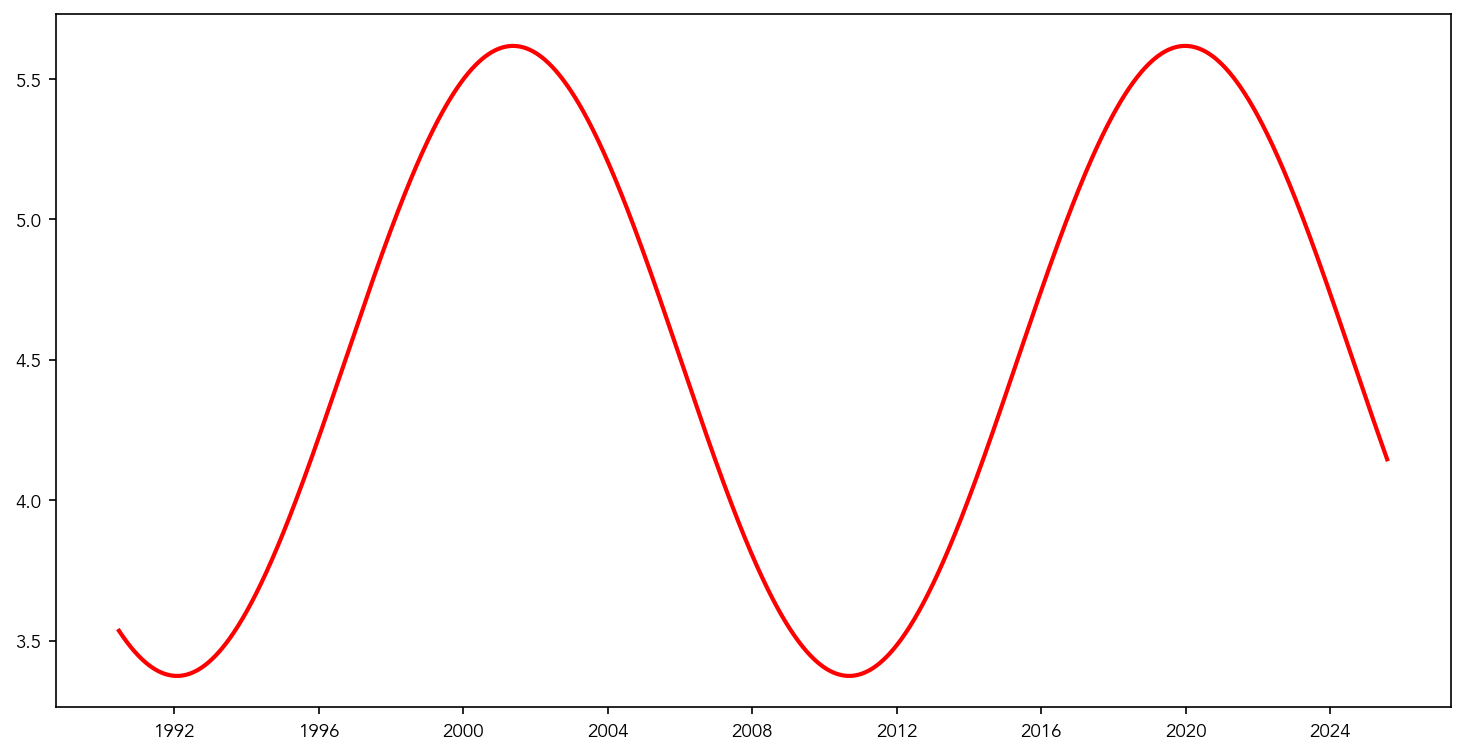

In [261]:
#plot ncyc_interp 
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], 0.1*ncyc_interp, label='Nodal Cycle Upper Envelope', color='red', linewidth=2)

In [262]:

def filter_ntr(ntr_data):
    # ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs,1/annual , width=widthSeasonal)
    # ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, 1/semiannual, width=widthSeasonal)
    # ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, 1/qtrannual, width=widthSeasonal)
    # ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

    rec_length = (ntr_data['time'].max() - ntr_data['time'].min()).days
    
    # if rec_length < 35*365.25:
        #interdecadal
        # ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
        #decadal
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr'], time_diffs, 1/decadal, order=3) 
    #     ntr_decadal = ntr_decadal + ntr_interdecadal
    # else:
    #     #interdecadal
    #     ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
    #     #decadal
    #     ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/decadal, order=3)
    
    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=3)

    # intraannual
    # this should be done in wavelets instead of a lowpass filter??

    ntr_subannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/monthly, order=5)

    ntr_monthly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/daily, order=5)

    rank_tide = ntr_data['tide'].rank(method='first', ascending=False)

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr'], 
                             'sea_level': ntr_data['sea_level'],
                             'sea_level_detrended': ntr_data['sea_level_detrended'],
                             'tide': ntr_data['tide'],
                             'Nodal Amp': ncyc_interp.values-ncyc_interp.mean(),
                             'Nodal Mod': ntr_data['nodal'],
                             'Perigean': perigean_cycle.values,
                             'Trend': ntr_data['trend'],
                            #  'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_data['seasonal_cycle'], 
                             'Subannual': ntr_subannual, 
                             'Monthly': ntr_monthly,
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq,
                             'Rank Tide': rank_tide } )
                        #    'NTR Trend': ntr_trend_series['ntr']
    # if rec_length < 35*365.25:
    #     ntr_filtered.pop('Interdecadal')

    component_names = list(ntr_filtered.columns) 
    component_names.remove('time')
    component_names.remove('ntr')
    component_names.remove('sea_level')
    component_names.remove('sea_level_detrended')
    component_names.remove('Nodal Amp')
    component_names.remove('Nodal Mod')

    # add trend back into ntr
    # ntr_filtered['ntr'] = ntr_filtered['ntr'] + ntr_filtered['NTR Trend']
    
    return ntr_filtered, component_names


In [263]:
ntr_filtered,component_names = filter_ntr(ntr_data)

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')
ntr_component_stds = ntr_component_stds.drop('Rank Tide')


Filled 1 % of data with noise (std = 63.4855).


In [264]:
# save ntr_component_stds to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_stds.csv')
ntr_component_stds.to_csv(savepath)


In [265]:
# look at filtered components of nodal cycle only
# nodal_data = ntr_data.copy()
# nodal_data.index = ntr_data['time']
# envelope_demeaned = envelope - np.nanmean(envelope)
# envelope_demeaned.index = nodal_data.index
# nodal_data['ntr_detrended'] = envelope_demeaned
# nodal_filtered = filter_ntr(nodal_data)

# #rename "ntr" in nodal_filtered to "nodal upper envelope"
# nodal_filtered = nodal_filtered.rename(columns={'ntr': 'nodal envelope'})

# nodal_component_std = nodal_filtered.std() 
# nodal_component_std = nodal_component_std.drop('time')



In [266]:
ntr_filtered

time         ntr  sea_level  sea_level_detrended  \
0      1990-06-20 21:00:00  143.956763      570.0          -336.826945   
1      1990-06-20 22:00:00  177.380975      400.0          -506.827768   
2      1990-06-20 23:00:00  148.746909      310.0          -596.828591   
3      1990-06-21 00:00:00  148.901945      410.0          -496.829414   
4      1990-06-21 01:00:00  128.183924      630.0          -276.830238   
...                    ...         ...        ...                  ...   
307798 2025-07-31 19:00:00  -84.458320      665.0          -495.164926   
307799 2025-07-31 20:00:00 -101.800440      774.0          -386.165749   
307800 2025-07-31 21:00:00  -80.975979      976.0          -184.166572   
307801 2025-07-31 22:00:00  -93.341502     1154.0            -6.167395   
307802 2025-07-31 23:00:00  -69.882393     1324.0           163.831782   

              tide  Nodal Amp  Nodal Mod   Perigean        Trend    Decadal  \
0      -480.783708 -10.018700  10.439206  -8.588247   906.826945  73.744964   
1      -684.208743 -10.018923   0.618843  -8.586413   906.827768  73.741832   
2      -745.575500 -10.019145  -8.449450  -8.584579   906.828591  73.738700   
3      -645.731359 -10.019368 -13.284231  -8.582744   906.829414  73.735568   
4      -405.014161 -10.019591 -11.023748  -8.580910   906.830238  73.732436   
...            ...        ...        ...        ...          ...        ...   
307798 -410.706605  -3.910585  -9.743810 -12.562899  1160.164926  13.163533   
307799 -284.365309  -3.910995  -4.428355 -12.561626  1160.165749  13.163533   
307800 -103.190593  -3.911406   3.749482 -12.560352  1160.166572  13.163533   
307801   87.174108  -3.911816  13.180628 -12.559079  1160.167395  13.163533   
307802  233.714175  -3.912227  20.987799 -12.557805  1160.168218  13.163533   

        Interannual   Seasonal  Subannual    Monthly     Weekly  Storms & HF  \
0         11.110461 -37.078174  17.174703   0.252467  23.008540    18.665628   
1         11.096745 -37.078174  17.149059   0.135903  22.737508    52.519927   
2         11.083026 -37.078174  17.123410   0.019159  22.450542    24.332071   
3         11.069305 -37.464199  17.097754  -0.097761  22.147690    24.949388   
4         11.055581 -37.464199  17.072092  -0.214854  21.829016     4.709653   
...             ...        ...        ...        ...        ...          ...   
307798   -64.606512 -47.324892 -21.351868 -13.044824 -34.513555    35.894906   
307799   -64.606512 -47.324892 -21.351868 -13.044824 -34.511579    18.550811   
307800   -64.606512 -47.324892 -21.351868 -13.044824 -34.509984    39.373677   
307801   -64.606512 -47.324892 -21.351868 -13.044824 -34.508711    27.006880   
307802   -64.606512 -47.324892 -21.351868 -13.044824 -34.507708    50.464987   

        Rank Tide  
0        272125.0  
1        303689.0  
2        306250.0  
3        300940.0  
4        249917.0  
...           ...  
307798   251654.0  
307799   214461.0  
307800   174076.0  
307801   136580.0  
307802   105938.0  

[307803 rows x 17 columns]

In [267]:
# ntr_component_stds

In [268]:
# nodal_component_std
# nodal_corr = nodal_filtered.drop(['time','sea_level','tide'], axis=1).corr()
# #plot heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(nodal_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
# plt.title('Correlation Matrix\n of upper nodal envelope components')

Note that to define the upper envelope we used monthly maxima. So there should be NO correlation in the weekly/storms.

Next, a sanity check to make sure that everything adds up to the right sum.

In [269]:
component_names
#remove Trend from component names
toRemove = ['Trend', 'Perigean', 'Seasonal','Rank Tide']
for remove in toRemove:
    if remove in component_names:
        component_names.remove(remove)


# component_names.remove('NTR Trend')

In [270]:
component_names

['tide',
 'Decadal',
 'Interannual',
 'Subannual',
 'Monthly',
 'Weekly',
 'Storms & HF']

Text(0.5, 1.0, 'Sum of components vs Sea Level')

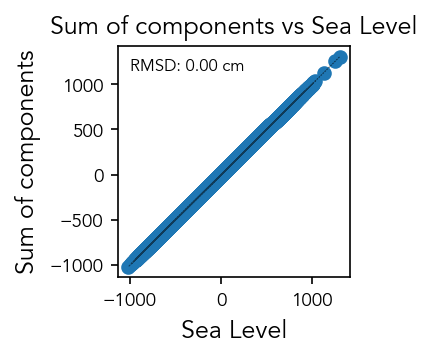

In [271]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))

# sum all components in components_names programmatically
ntr_sum = ntr_filtered[component_names].sum(axis=1)


#make a dotted 1:1 line
plt.plot(ntr_filtered['sea_level_detrended'], ntr_filtered['sea_level_detrended'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['sea_level_detrended'], ntr_sum)

plt.xlabel('Sea Level')
plt.ylabel('Sum of components')

# add RMSD to plot
rmsd = np.sqrt(np.mean((ntr_filtered['sea_level_detrended'] - ntr_sum)**2))
plt.text(0.05, 0.95, f'RMSD: {rmsd:.2f} cm', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Sum of components vs Sea Level')


In [272]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide', 'Nodal Amp',
       'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal',
       'Subannual', 'Monthly', 'Weekly', 'Storms & HF', 'Rank Tide'],
      dtype='object')

Text(0.5, 1.0, 'Correlation between each component')

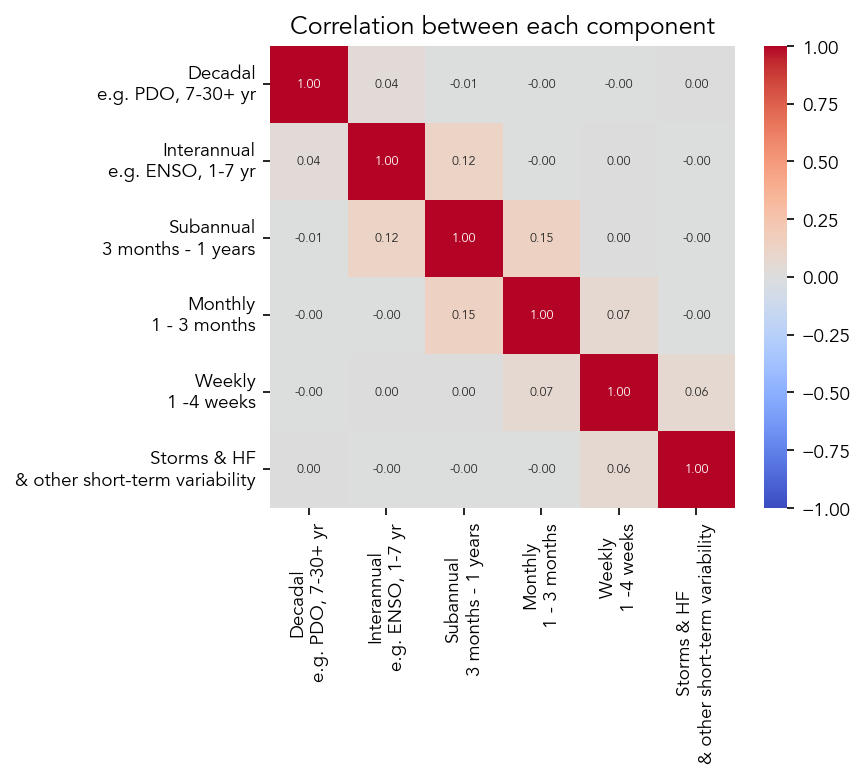

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','sea_level_detrended','tide','ntr','Nodal Amp','Nodal Mod','Trend','Seasonal','Perigean','Rank Tide'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [274]:
# get the cumulative sum of the components
ntr_component_names = component_names.copy()
ntr_component_names.remove('tide')
# move trend and Seasonal to the beginning of the list
# ntr_component_names.remove('Seasonal')
ntr_component_names.insert(0, 'Seasonal')
# ntr_component_names.remove('Rank Tide')
# ntr_component_names.remove('NTR Trend')
# ntr_component_names.insert(0, 'NTR Trend')
ntr_cumsum = ntr_filtered[ntr_component_names].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds


# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


Seasonal       33.194820
Decadal        41.817907
Interannual    52.657511
Subannual      59.542608
Monthly        63.938526
Weekly         67.444523
Storms & HF    71.075428
dtype: float64

In [275]:
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide', 'Nodal Amp',
       'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal',
       'Subannual', 'Monthly', 'Weekly', 'Storms & HF', 'Rank Tide'],
      dtype='object')

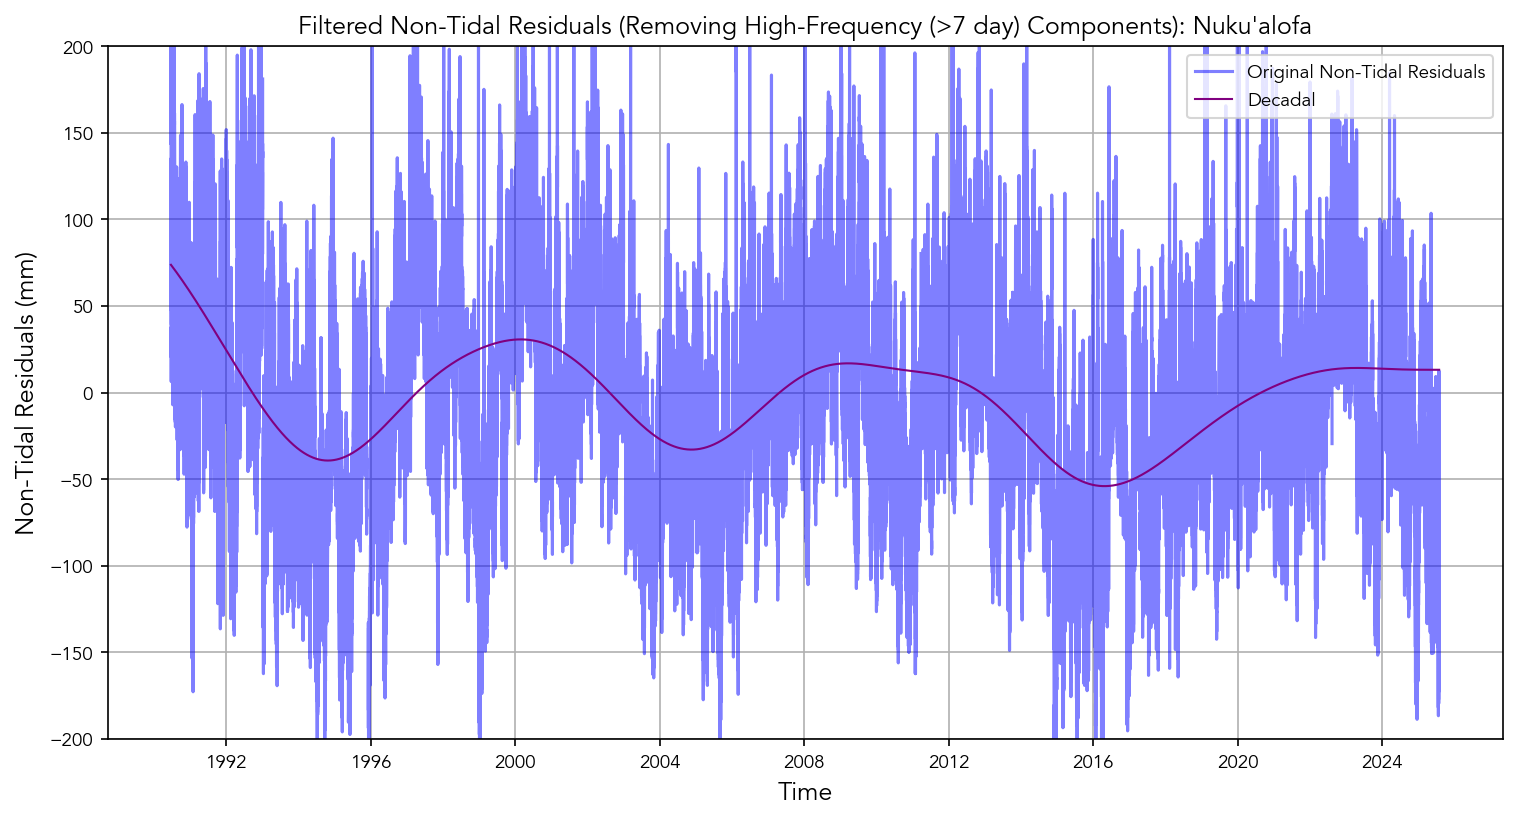

In [276]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['Nodal Amp'], label='Nodal Upper Envelope', color='green', linewidth=1)
# # plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Subannual'], label='Subannual', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Perigean'], label='Perigean', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Monthly'], label='Monthly', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Weekly'], label='Weekly', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR with Nodal Cycle')



plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
# plt.xlim(pd.Timestamp('2022-03-08'), pd.Timestamp('2025-3-18'))
plt.ylim(-200, 200)
plt.show()

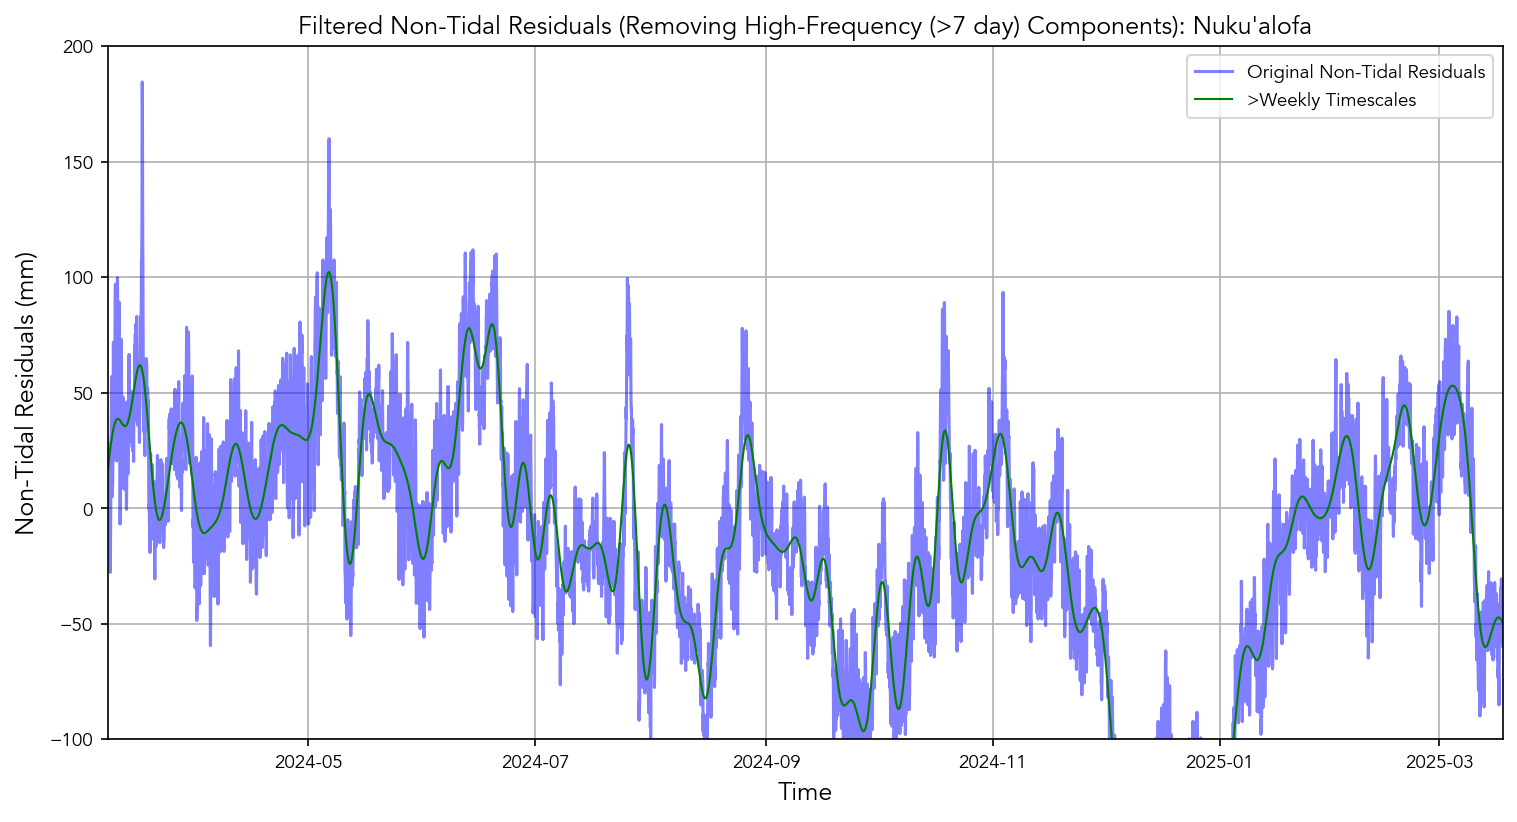

In [277]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

plt.plot(ntr_filtered['time'], ntr_filtered[['Decadal','Interannual','Subannual','Monthly','Weekly']].sum(axis=1), label='>Weekly Timescales', color='green', linewidth=1)
# # plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
# # plt.plot(ntr_filtered['time'], ntr_filtered['Subannual'], label='Subannual', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Perigean'], label='Perigean', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Monthly'], label='Monthly', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Weekly'], label='Weekly', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR with Nodal Cycle')



plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('2024-03-08'), pd.Timestamp('2025-3-18'))
plt.ylim(-100, 200)
plt.show()

In [278]:
ntr_filtered
#resample to monthly
ntr_filtered_monthly = ntr_filtered.resample('ME', on='time').mean()

Text(0.5, 1.0, 'Interannual NTR and ONI')

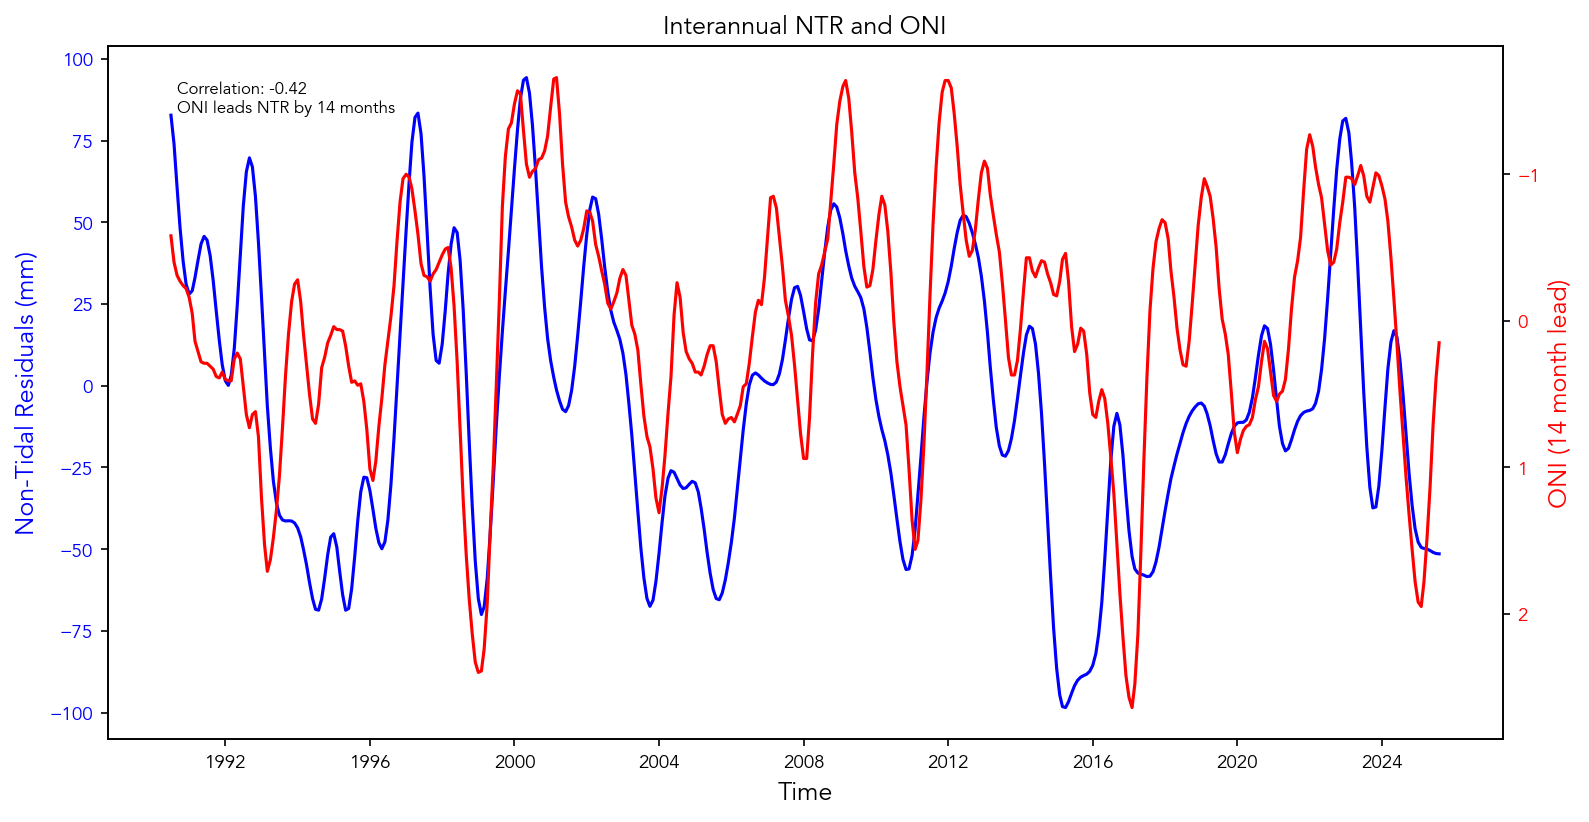

In [279]:
# Is the interannual component correlated with ENSO? Let's use the ONI index
# load ONI data

CI_dir = Path(data_dir / 'climate_indices')
climateIndex = ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

CIcorr = np.zeros((len(climateIndex), 30))

# Arrays to store peak correlation and lag for each climate index
CIcorr_max_peaks = np.zeros(len(climateIndex))
CIcorr_max_lag = np.zeros(len(climateIndex))

for indCI in range(len(climateIndex)):
    CI = pd.read_csv(CI_dir / (climateIndex[indCI] + '.csv'), parse_dates=['time'])
    # ntr_CI = pd.merge_asof(ntr_filtered_monthly.sort_index(), CI.sort_index(), left_index=True, right_index=True, direction='nearest')
    CI['time'] = pd.to_datetime(CI['time'])

    # Perform the merge
    ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
    # Define the number of lags
    lag = 30
    corr = np.zeros(lag)

    if climateIndex[indCI] == 'PDO' or climateIndex[indCI] == 'PMM': #<--- IS THIS CORRECT?
        # For PDO and PMM, we need to add the decadal component to the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual'] + ntr_CI['Decadal']
    else:
        # For other climate indices, we just use the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual']


    # Calculate lagged correlation
    for i in range(1, lag + 1):
        corr[i - 1] = np.corrcoef(ntr_CI[climateIndex[indCI]][:-i], ntr_CI['signal'][i:])[0, 1]
    CIcorr[indCI,:] = corr
    # get max correlation and lag
    CIcorr_max_peaks[indCI] = np.max(abs(CIcorr[indCI,:]))
    CIcorr_max_lag[indCI] = np.argmax(abs(CIcorr[indCI,:]))

# Use the max correlation to determine the winning Climate Index
climateIndex_bestcorr = climateIndex[np.argmax(abs(CIcorr_max_peaks))]
climateIndex_bestlag = CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))]

# now adjust the climateIndex by the lag and plot together with the ntr

CI = pd.read_csv(CI_dir / (climateIndex_bestcorr + '.csv'), parse_dates=['time'])
#adjust the time by the lag
CI['time'] = pd.to_datetime(CI['time'])
CI['time'] = CI['time'] + pd.DateOffset(months=CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))])
# Perform the merge
ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
# rename the columns

#plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ntr_CI['time'], ntr_CI['Interannual']+ntr_CI['Decadal'], label='Interannual NTR', color='blue')
# ax1.plot(ntr_CI['time'], ntr_CI['Decadal'], label='Decadal NTR', color='blue')

# plt.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Non-Tidal Residuals (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for ONI
ax2 = ax1.twinx()
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.set_ylabel(ylabel, color='red')
ax2.tick_params(axis='y', labelcolor='red')

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis

# add text for correlation
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}\n{climateIndex_bestcorr} leads NTR by {climateIndex_bestlag:.0f} months', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Interannual NTR and ' + climateIndex_bestcorr)

In [280]:
ntr_CI

ntr    sea_level  sea_level_detrended       tide  Nodal Amp  \
time                                                                            
1990-06-30  81.273746   947.905350            40.978814 -40.294932 -10.045520   
1990-07-31  81.058326   947.072581            39.739862 -41.318465 -10.152577   
1990-08-31  45.772671   908.745968             0.800888 -44.971783 -10.307756   
1990-09-30  46.426518   916.694444             8.146880 -38.279638 -10.452524   
1990-10-31  47.373715   935.833333            26.683285 -20.690430 -10.589267   
...               ...          ...                  ...        ...        ...   
2025-03-31 -28.746513  1170.119624            12.667111  41.413624  -2.533583   
2025-04-30 -59.390679  1115.095833           -42.959163  16.431516  -2.843164   
2025-05-31 -79.562371  1068.806452           -89.851029 -10.288658  -3.150801   
2025-06-30 -66.166118  1063.622222           -95.637743 -29.471624  -3.456273   
2025-07-31 -89.171920  1029.036290          -130.826159 -41.654239  -3.759311   

            Nodal Mod   Perigean        Trend    Decadal  Interannual  \
time                                                                    
1990-06-30   0.010880  -8.364780   906.926536  73.364845     9.425680   
1990-07-31   0.010504  -7.429874   907.332719  71.795455     2.253837   
1990-08-31  -0.009515  -5.968385   907.945080  69.380419    -8.740090   
1990-09-30   0.035649  -4.483637   908.547564  66.945461   -18.639702   
1990-10-31  -0.072013  -2.974728   909.150048  64.454939   -26.332552   
...               ...        ...          ...        ...          ...   
2025-03-31   0.370303 -15.043711  1157.452513  13.169600   -63.127293   
2025-04-30   0.591891 -14.808469  1158.054997  13.165939   -63.589179   
2025-05-31   0.494767 -14.383583  1158.657481  13.164232   -64.153462   
2025-06-30   0.289911 -13.779430  1159.259965  13.163643   -64.507492   
2025-07-31   0.068090 -13.004926  1159.862449  13.163537   -64.601773   

             Seasonal  Subannual    Monthly     Weekly  Storms & HF  \
time                                                                  
1990-06-30 -39.058366  14.036233 -13.095657  -4.483613     2.026258   
1990-07-31 -44.606661   1.778292   1.236874   3.657820     0.336048   
1990-08-31 -47.834110 -10.496148  -1.873701  -2.261587    -0.236222   
1990-09-30 -42.876969  -3.972262   1.438136   0.980416    -0.325530   
1990-10-31 -27.248036  12.553636  -3.040065  -0.408930     0.146687   
...               ...        ...        ...        ...          ...   
2025-03-31  27.980103  29.511361 -13.196002   4.910992    -0.015170   
2025-04-30   4.367340 -16.866662  10.347485  -2.576670     0.128407   
2025-05-31 -18.408258 -24.817303  -3.250222  -0.308394    -0.197222   
2025-06-30 -34.968048 -22.316593   4.569483   2.808716     0.116124   
2025-07-31 -44.606661 -21.381403  -3.442853 -15.811326     2.901899   

                Rank Tide       time   ONI  
time                                        
1990-06-30  162231.292181 1990-07-01 -0.58  
1990-07-31  163694.815860 1990-08-01 -0.40  
1990-08-31  164610.157258 1990-09-01 -0.31  
1990-09-30  163037.600000 1990-10-01 -0.27  
1990-10-31  158799.763441 1990-11-01 -0.24  
...                   ...        ...   ...  
2025-03-31  144512.348118 2025-04-01  1.48  
2025-04-30  150074.205556 2025-05-01  1.14  
2025-05-31  156135.568548 2025-06-01  0.71  
2025-06-30  160794.423611 2025-07-01  0.39  
2025-07-31  163779.895161 2025-08-01  0.15  

[422 rows x 18 columns]

In [281]:
# ntr_components_stds = ntr

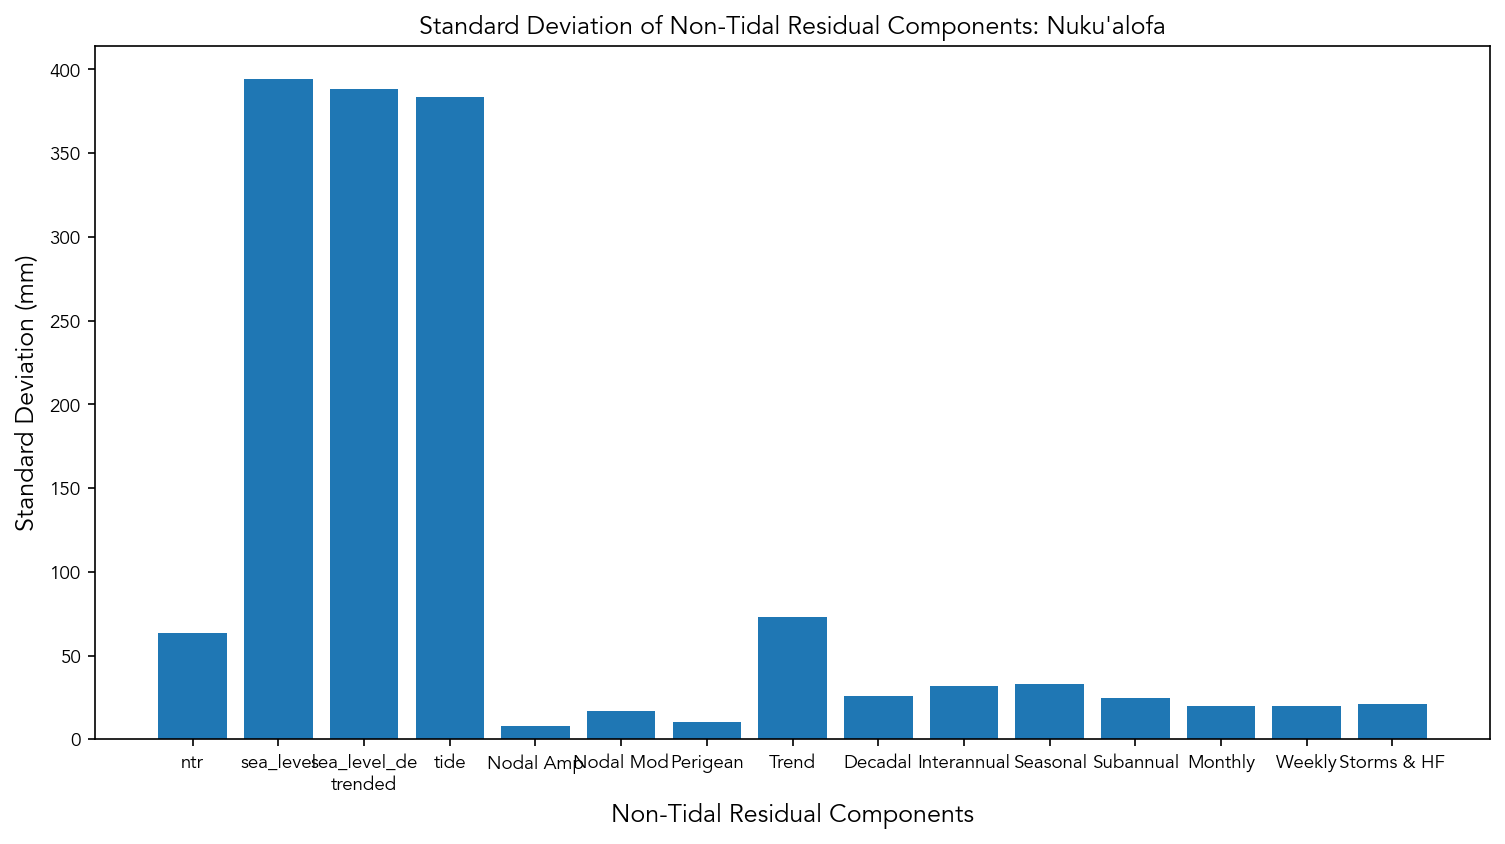

In [282]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ntr_component_stds.index, ntr_component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in ntr_component_stds.index]
plt.xticks(range(len(ntr_component_stds.index)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [283]:
ntr_filtered

time         ntr  sea_level  sea_level_detrended  \
0      1990-06-20 21:00:00  143.956763      570.0          -336.826945   
1      1990-06-20 22:00:00  177.380975      400.0          -506.827768   
2      1990-06-20 23:00:00  148.746909      310.0          -596.828591   
3      1990-06-21 00:00:00  148.901945      410.0          -496.829414   
4      1990-06-21 01:00:00  128.183924      630.0          -276.830238   
...                    ...         ...        ...                  ...   
307798 2025-07-31 19:00:00  -84.458320      665.0          -495.164926   
307799 2025-07-31 20:00:00 -101.800440      774.0          -386.165749   
307800 2025-07-31 21:00:00  -80.975979      976.0          -184.166572   
307801 2025-07-31 22:00:00  -93.341502     1154.0            -6.167395   
307802 2025-07-31 23:00:00  -69.882393     1324.0           163.831782   

              tide  Nodal Amp  Nodal Mod   Perigean        Trend    Decadal  \
0      -480.783708 -10.018700  10.439206  -8.588247   906.826945  73.744964   
1      -684.208743 -10.018923   0.618843  -8.586413   906.827768  73.741832   
2      -745.575500 -10.019145  -8.449450  -8.584579   906.828591  73.738700   
3      -645.731359 -10.019368 -13.284231  -8.582744   906.829414  73.735568   
4      -405.014161 -10.019591 -11.023748  -8.580910   906.830238  73.732436   
...            ...        ...        ...        ...          ...        ...   
307798 -410.706605  -3.910585  -9.743810 -12.562899  1160.164926  13.163533   
307799 -284.365309  -3.910995  -4.428355 -12.561626  1160.165749  13.163533   
307800 -103.190593  -3.911406   3.749482 -12.560352  1160.166572  13.163533   
307801   87.174108  -3.911816  13.180628 -12.559079  1160.167395  13.163533   
307802  233.714175  -3.912227  20.987799 -12.557805  1160.168218  13.163533   

        Interannual   Seasonal  Subannual    Monthly     Weekly  Storms & HF  \
0         11.110461 -37.078174  17.174703   0.252467  23.008540    18.665628   
1         11.096745 -37.078174  17.149059   0.135903  22.737508    52.519927   
2         11.083026 -37.078174  17.123410   0.019159  22.450542    24.332071   
3         11.069305 -37.464199  17.097754  -0.097761  22.147690    24.949388   
4         11.055581 -37.464199  17.072092  -0.214854  21.829016     4.709653   
...             ...        ...        ...        ...        ...          ...   
307798   -64.606512 -47.324892 -21.351868 -13.044824 -34.513555    35.894906   
307799   -64.606512 -47.324892 -21.351868 -13.044824 -34.511579    18.550811   
307800   -64.606512 -47.324892 -21.351868 -13.044824 -34.509984    39.373677   
307801   -64.606512 -47.324892 -21.351868 -13.044824 -34.508711    27.006880   
307802   -64.606512 -47.324892 -21.351868 -13.044824 -34.507708    50.464987   

        Rank Tide  
0        272125.0  
1        303689.0  
2        306250.0  
3        300940.0  
4        249917.0  
...           ...  
307798   251654.0  
307799   214461.0  
307800   174076.0  
307801   136580.0  
307802   105938.0  

[307803 rows x 17 columns]

In [284]:
# does the total variance of the components equal the variance of the ntr?

# get the variance of each component
components = ['Decadal','Interannual','Subannual','Monthly','Weekly','Storms & HF']
ntr_component_vars = ntr_filtered[components].var()

# get the sum of the variances
ntr_component_vars_sum = ntr_component_vars.sum()
# get the variance of the ntr
ntr_var =ntr_filtered['ntr'].var()

print('Sum of variances of components:', ntr_component_vars_sum)
print('Variance of ntr:', ntr_var)


print('"Wave Height" contributions:', 0.4* np.sqrt(ntr_component_vars_sum))
print('"Wave Height" ntr:', 0.4 * np.sqrt(ntr_var))

ntr_component_vars

# save ntr_component_vars to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_vars2.csv')
ntr_component_vars.to_csv(savepath)



Sum of variances of components: 3536.312537684421
Variance of ntr: 4030.4224296528637
"Wave Height" contributions: 23.78676115046997
"Wave Height" ntr: 25.39424322055017


In [285]:
ntr_data

time         ntr   ntr_noASA  sea_level  \
0      1990-06-20 21:00:00  143.956763  111.854563      570.0   
1      1990-06-20 22:00:00  177.380975  145.258362      400.0   
2      1990-06-20 23:00:00  148.746909  116.603899      310.0   
3      1990-06-21 00:00:00  148.901945  116.738555      410.0   
4      1990-06-21 01:00:00  128.183924   96.000169      630.0   
...                    ...         ...         ...        ...   
307798 2025-07-31 19:00:00  -84.458320 -128.754693      665.0   
307799 2025-07-31 20:00:00 -101.800440 -146.101347      774.0   
307800 2025-07-31 21:00:00  -80.975979 -125.281403      976.0   
307801 2025-07-31 22:00:00  -93.341502 -137.651428     1154.0   
307802 2025-07-31 23:00:00  -69.882393 -114.196803     1324.0   

        sea_level_detrended        trend        tide      nodal  \
0               -336.826945   906.826945 -480.783708  10.439206   
1               -506.827768   906.827768 -684.208743   0.618843   
2               -596.828591   906.828591 -745.575500  -8.449450   
3               -496.829414   906.829414 -645.731359 -13.284231   
4               -276.830238   906.830238 -405.014161 -11.023748   
...                     ...          ...         ...        ...   
307798          -495.164926  1160.164926 -410.706605  -9.743810   
307799          -386.165749  1160.165749 -284.365309  -4.428355   
307800          -184.166572  1160.166572 -103.190593   3.749482   
307801            -6.167395  1160.167395   87.174108  13.180628   
307802           163.831782  1160.168218  233.714175  20.987799   

        ntr_withNodal  seasonal_cycle  dayofyear  ntr_detrended  
0          133.517557      -37.078174        171     138.301470  
1          176.762131      -37.078174        171     171.725758  
2          157.196359      -37.078174        171     143.091767  
3          162.186176      -37.464199        172     143.246879  
4          139.207672      -37.464199        172     122.528934  
...               ...             ...        ...            ...  
307798     -74.714511      -47.324892        212     -66.757305  
307799     -97.372085      -47.324892        212     -84.099349  
307800     -84.725461      -47.324892        212     -63.274812  
307801    -106.522130      -47.324892        212     -75.640260  
307802     -90.870192      -47.324892        212     -52.181075  

[307803 rows x 12 columns]

In [286]:
# "wave height" of each component
ntr_component_waveheight = ntr_cumsum_stds/10 *4
ntr_component_waveheight

# add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# get trend rate from ntr_data['NTR Trend'] 
SLR = ntr_filtered[['Trend','time']].copy()
# set time as index
SLR['time'] = pd.to_datetime(SLR['time'])
SLR.set_index('time', inplace=True)
# get the slope of the trend - it is linear so just a-b over time
SLR_mm_day = (SLR['Trend'].iloc[-1] - SLR['Trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

SLR_cm30yr = SLR_mm_day*365.25/10 # convert to cm/yr

ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)


# # add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# # get trend rate from ntr_data['trend'] 
# SLR = ntr_data[['trend','time']].copy()
# # set time as index
# SLR['time'] = pd.to_datetime(SLR['time'])
# SLR.set_index('time', inplace=True)
# # get the slope of the trend - it is linear so just a-b over time
# SLR_mm_day = (SLR['trend'].iloc[-1] - SLR['trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

# SLR_cm30yr = SLR_mm_day*365.25/10 # convert to cm/yr

# ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)

ntr_component_waveheight


Long-Term Trend     0.721504
Seasonal           13.999432
Decadal            17.448667
Interannual        21.784509
Subannual          24.538547
Monthly            26.296915
Weekly             27.699313
Storms & HF        29.151675
dtype: float64

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/9w/vpws17h965v7n60fmhp97k5r0000gq/T/ipykernel_40303/2566925628.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))


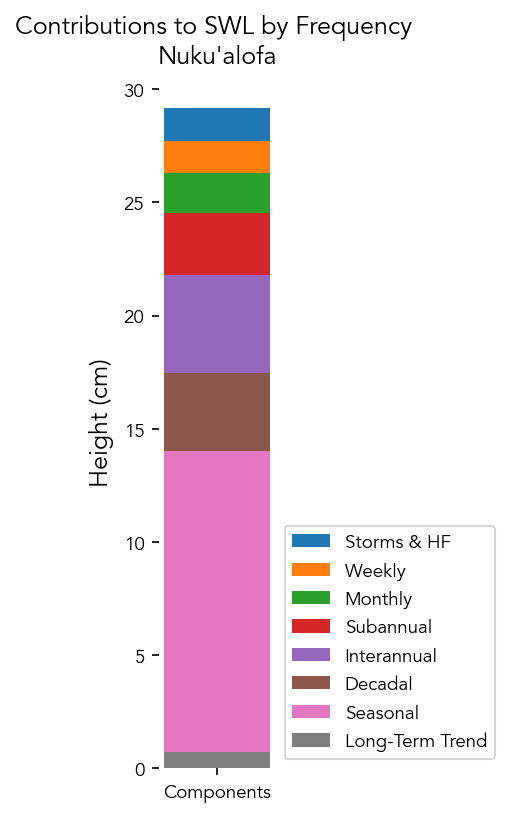

In [287]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))
# ntr_component_vars_cumsum = ntr_component_vars.cumsum()/ntr_component_vars_sum * ntr_var #normalize to the variance of the ntr (not filtered)
# Plot stacked bars
bottom = 0
for i in range(len(ntr_component_waveheight.index)-1, -1, -1):
    ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (cm)')
ax.set_title('Contributions to SWL by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)

# save the wave height to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_waveheight.csv')
ntr_component_waveheight.to_csv(savepath)


In [288]:
# combine all Path(data_dir, f'ntr_data/ntr_{station:03d}_component_waveheight.csv') into one plot
# get all the csv files in ntr_data
import glob
# get all the csv files in ntr_data
ntr_data_dir = Path(data_dir, 'ntr_data')
ntr_data_files = glob.glob(os.path.join(ntr_data_dir, '*component_waveheight.csv'))

# only include stations in ds
stations = set(ds.station_id.values)

# Filter files to only those in the Pacific set
ntr_data_files = [
    f for f in ntr_data_files
    if int(Path(f).stem.split('_')[1]) in stations
]

# Read and tag each file
df_list = []
for file in ntr_data_files:
    df = pd.read_csv(file, index_col=None)
    df.columns = ['station', station]
    df_list.append(df)

# Combine into one DataFrame

ntr_combined = pd.concat(
    {df.columns[1]: df.set_index('station').iloc[:, 0] for df in df_list},
    axis=1
)

ntr_combined = ntr_combined[sorted(ntr_combined.columns)]

ntr_combined
# # subtract first row from all rows
# ntr_combined = ntr_combined.sub(ntr_combined.iloc[0], axis=1)
# # delete the first row
# ntr_combined = ntr_combined.drop(ntr_combined.index[0])
#divide all by the last row
ntr_combined_norm = ntr_combined.div(ntr_combined.iloc[-1], axis=1)
ntr_combined_norm

38
station                  
Long-Term Trend  0.012437
Seasonal         0.539742
Decadal          0.585236
Interannual      0.807589
Subannual        0.891949
Monthly          0.935818
Weekly           0.955030
Storms & HF      1.000000

In [289]:

ds.station_id.values

array([25, 38])

In [290]:
ds.station_name.values

array(['Funafuti', "Nuku'alofa"], dtype='<U10')

In [291]:
#only run if combined norm has more than 1 column
if ntr_combined_norm.shape[1] > 1:

    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(10, 6))  # adjust width based on number of stations
    
    # remove French Frigate, Kaumalapau, and Barbers Point
    # remove 552
    # stations = [station for station in stations if station != 552]
    stations = [station for station in stations if station != 548]
    stations = [station for station in stations if station != 14]
    stations = [station for station in stations if station != 547]
    
    
    # get latitude of stations
    latitudes = ds.lat.sel(station_id=stations).values
    # sort by latitude
    
    sorted_indices = np.argsort(latitudes)
    # sort stations by latitude
    stations = np.array(stations)[sorted_indices]
    
    # Get the components
    ntr_combined_norm = ntr_combined_norm[stations]
    ntr_combined = ntr_combined[stations]
    components = ntr_combined.index
    x = np.arange(len(stations))  # one x-position per station
    
    # Set color palette
    colors = plt.cm.tab20(np.linspace(0, 1, len(components)))
    
    # Plot each component
    bottom = np.zeros(len(stations))
    for i, component in reversed(list(enumerate(components))):
        heights = ntr_combined.loc[component].values
        ax.bar(x, heights, bottom=0, label=component.replace('\n', ' '))
        bottom += heights
    
    #names of stations instead of numbers, make a dictionary
    station_names = ds.station_name.sel(station_id=stations).values
    
    # Customize axes
    ax.set_ylabel("Contribution to NTR (cm)")
    ax.set_xlabel("Station")
    ax.set_title("Components by Frequency and Station")
    ax.set_xticks(x)
    ax.set_xticklabels(station_names, rotation=45, horizontalalignment='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Remove box
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    


It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be directly added together to represent the total variances of the whole signal. (See the correlation plot above.)

In [292]:
station_name

"Nuku'alofa"

In [293]:
output_dir
# replace juliafiedler with jfiedler
from pathlib import Path

output_dir = Path('/Users/juliafiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output/')

In [294]:
output_dir

PosixPath('/Users/juliafiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output')

In [295]:
# get dates of extreme events
station_name_1st = station_name.split(',')[0]
top10tableNameNew = 'SL_top_10_table_' + station_name_1st + '_new.csv'
top10tableName = 'SL_top_10_table_' + station_name_1st + '.csv'

#temporarily set the output_dir to ../output
# output_dir = Path('../output')
output_dir = Path(data_dir, '../output')
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [296]:
extremes

Rank   Highest      Highest Date Highest ONI Mode    Lowest  \
0      1  0.841396  2020-04-08 19:00          Neutral -1.625604   
1      2  0.527396  2014-03-01 06:00          Neutral -1.605604   
2      3  0.505396  2022-01-03 07:00          La Nina -1.605604   
3      4  0.477396  2010-02-15 08:00          El Nino -1.595604   
4      5  0.446396  2009-01-11 06:00          Neutral -1.575604   
5      6  0.445396  2020-10-17 07:00          Neutral -1.575604   
6      7  0.432396  2020-12-15 07:00          La Nina -1.575604   
7      8  0.427396  2023-02-21 07:00          Neutral -1.565604   
8      9  0.421396  2022-12-26 09:00          La Nina -1.565604   
9     10  0.419396  2012-02-14 00:00          La Nina -1.565604   
10    11  0.419396  2024-02-11 08:00          El Nino -1.562604   
11    12  0.416396  2020-01-18 01:00          Neutral -1.555604   
12    13  0.416396  2021-12-04 06:00          Neutral -1.553604   
13    14  0.413396  2012-04-08 20:00          Neutral -1.545604   
14    15  0.413396  2023-01-23 08:00          Neutral -1.545604   
15    16  0.407396  2024-10-19 08:00          Neutral -1.535604   
16    17  0.406396  2017-12-04 07:00          Neutral -1.530604   
17    18  0.403396  2024-03-10 19:00          El Nino -1.526604   
18    19  0.402396  2015-03-21 20:00          Neutral -1.525604   
19    20  0.398396  2024-05-07 18:00          Neutral -1.525604   

         Lowest Date Lowest ONI Mode Zone  ONI max  ONI min  
0   1995-06-14 01:00         Neutral  GMT     0.19    -0.03  
1   1994-06-24 01:00         Neutral  GMT    -0.27     0.44  
2   1995-05-16 02:00         Neutral  GMT    -0.97     0.14  
3   1995-12-23 14:00         La Nina  GMT     0.84    -0.90  
4   1993-10-16 13:00         Neutral  GMT    -0.85     0.04  
5   1994-04-27 02:00         Neutral  GMT    -1.27     0.42  
6   1994-11-05 14:00         Neutral  GMT    -1.19     1.01  
7   1993-07-21 02:00         Neutral  GMT    -0.15     0.25  
8   1993-11-15 14:00         Neutral  GMT    -0.68     0.04  
9   1994-07-23 01:00         Neutral  GMT    -0.72     0.43  
10  1999-01-02 13:00         La Nina  GMT     1.48    -1.55  
11  1996-07-31 01:00         Neutral  GMT     0.48    -0.32  
12  1999-06-15 02:00         La Nina  GMT    -0.98    -1.04  
13  1993-09-17 01:00         Neutral  GMT    -0.47     0.10  
14  1996-06-03 02:00         Neutral  GMT    -0.43    -0.30  
15  1995-07-14 02:00         Neutral  GMT    -0.37    -0.24  
16  2001-08-21 02:00         Neutral  GMT    -0.97    -0.19  
17  2003-10-27 14:00         Neutral  GMT     1.14     0.35  
18  1996-07-03 02:00         Neutral  GMT     0.70    -0.27  
19  2010-08-12 02:00         Neutral  GMT     0.39    -1.35

In [297]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

# CAUTION MANUAL ENTRY HERE
# add Oct 19 2024 8 am to extremes_highest for Nuku'alofa
extremes_highest = np.append(extremes_highest, pd.to_datetime('2024-10-19 08:00:00'))


extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest





DatetimeIndex(['2020-04-08 19:00:00', '2014-03-01 06:00:00',
               '2022-01-03 07:00:00', '2010-02-15 08:00:00',
               '2009-01-11 06:00:00', '2020-10-17 07:00:00',
               '2020-12-15 07:00:00', '2023-02-21 07:00:00',
               '2022-12-26 09:00:00', '2012-02-14 00:00:00',
               '2024-02-11 08:00:00', '2020-01-18 01:00:00',
               '2021-12-04 06:00:00', '2012-04-08 20:00:00',
               '2023-01-23 08:00:00', '2024-10-19 08:00:00',
               '2017-12-04 07:00:00', '2024-03-10 19:00:00',
               '2015-03-21 20:00:00', '2024-05-07 18:00:00',
               '2024-10-19 08:00:00'],
              dtype='datetime64[ns]', freq=None)

In [298]:
ntr_filtered

time         ntr  sea_level  sea_level_detrended  \
0      1990-06-20 21:00:00  143.956763      570.0          -336.826945   
1      1990-06-20 22:00:00  177.380975      400.0          -506.827768   
2      1990-06-20 23:00:00  148.746909      310.0          -596.828591   
3      1990-06-21 00:00:00  148.901945      410.0          -496.829414   
4      1990-06-21 01:00:00  128.183924      630.0          -276.830238   
...                    ...         ...        ...                  ...   
307798 2025-07-31 19:00:00  -84.458320      665.0          -495.164926   
307799 2025-07-31 20:00:00 -101.800440      774.0          -386.165749   
307800 2025-07-31 21:00:00  -80.975979      976.0          -184.166572   
307801 2025-07-31 22:00:00  -93.341502     1154.0            -6.167395   
307802 2025-07-31 23:00:00  -69.882393     1324.0           163.831782   

              tide  Nodal Amp  Nodal Mod   Perigean        Trend    Decadal  \
0      -480.783708 -10.018700  10.439206  -8.588247   906.826945  73.744964   
1      -684.208743 -10.018923   0.618843  -8.586413   906.827768  73.741832   
2      -745.575500 -10.019145  -8.449450  -8.584579   906.828591  73.738700   
3      -645.731359 -10.019368 -13.284231  -8.582744   906.829414  73.735568   
4      -405.014161 -10.019591 -11.023748  -8.580910   906.830238  73.732436   
...            ...        ...        ...        ...          ...        ...   
307798 -410.706605  -3.910585  -9.743810 -12.562899  1160.164926  13.163533   
307799 -284.365309  -3.910995  -4.428355 -12.561626  1160.165749  13.163533   
307800 -103.190593  -3.911406   3.749482 -12.560352  1160.166572  13.163533   
307801   87.174108  -3.911816  13.180628 -12.559079  1160.167395  13.163533   
307802  233.714175  -3.912227  20.987799 -12.557805  1160.168218  13.163533   

        Interannual   Seasonal  Subannual    Monthly     Weekly  Storms & HF  \
0         11.110461 -37.078174  17.174703   0.252467  23.008540    18.665628   
1         11.096745 -37.078174  17.149059   0.135903  22.737508    52.519927   
2         11.083026 -37.078174  17.123410   0.019159  22.450542    24.332071   
3         11.069305 -37.464199  17.097754  -0.097761  22.147690    24.949388   
4         11.055581 -37.464199  17.072092  -0.214854  21.829016     4.709653   
...             ...        ...        ...        ...        ...          ...   
307798   -64.606512 -47.324892 -21.351868 -13.044824 -34.513555    35.894906   
307799   -64.606512 -47.324892 -21.351868 -13.044824 -34.511579    18.550811   
307800   -64.606512 -47.324892 -21.351868 -13.044824 -34.509984    39.373677   
307801   -64.606512 -47.324892 -21.351868 -13.044824 -34.508711    27.006880   
307802   -64.606512 -47.324892 -21.351868 -13.044824 -34.507708    50.464987   

        Rank Tide  
0        272125.0  
1        303689.0  
2        306250.0  
3        300940.0  
4        249917.0  
...           ...  
307798   251654.0  
307799   214461.0  
307800   174076.0  
307801   136580.0  
307802   105938.0  

[307803 rows x 17 columns]

In [299]:
# use ds to find highest 5 sea levels in 2024
sea_2024 = ds.sea_level.sel(station_id=station).sel(time=slice('2024-01-01', '2024-12-31'))
sea_2024_pd = sea_2024.to_series()
top5 = sea_2024_pd.nlargest(10)
top5

time
2024-02-11 08:00:00    2005.0
2024-10-19 08:00:00    1993.0
2024-03-10 19:00:00    1989.0
2024-03-11 20:00:00    1985.0
2024-05-07 18:00:00    1984.0
2024-02-11 07:00:00    1981.0
2024-02-12 21:00:00    1981.0
2024-02-10 07:00:00    1978.0
2024-05-06 17:00:00    1977.0
2024-03-12 21:00:00    1976.0
Name: sea_level, dtype: float32

In [300]:
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_high

time         ntr  sea_level  sea_level_detrended  \
162705 2009-01-11 06:00:00  187.189873     2032.0           991.256148   
172307 2010-02-15 08:00:00  479.967499     2063.0          1014.353071   
189795 2012-02-14 00:00:00  242.466748     2005.0           941.959298   
191111 2012-04-08 20:00:00  113.966552     1999.0           934.876143   
207705 2014-03-01 06:00:00  230.066246     2113.0          1035.218191   
216959 2015-03-21 20:00:00   58.894169     1988.0           902.601541   
240682 2017-12-04 07:00:00   69.976324     1992.0           887.075953   
259276 2020-01-18 01:00:00  194.514175     2002.0           881.771869   
261238 2020-04-08 19:00:00  488.398731     2427.0          1305.157014   
265834 2020-10-17 07:00:00  135.233578     2031.0           905.374204   
267250 2020-12-15 07:00:00   81.597930     2018.0           891.208743   
275745 2021-12-04 06:00:00   61.767502     2002.0           868.216800   
276466 2022-01-03 07:00:00  122.372172     2091.0           956.623369   
285036 2022-12-26 09:00:00   71.888397     2007.0           865.569696   
285707 2023-01-23 08:00:00   17.547392     1999.0           857.017419   
286402 2023-02-21 07:00:00   59.752792     2013.0           870.445388   
294923 2024-02-11 08:00:00   43.879238     2005.0           855.432045   
295606 2024-03-10 19:00:00   67.357602     1989.0           838.869892   
296997 2024-05-07 18:00:00   83.690194     1984.0           832.725007   
300947 2024-10-19 08:00:00   57.996897     1993.0           838.473898   

              tide  Nodal Amp  Nodal Mod   Perigean        Trend    Decadal  \
162705  804.066275  -9.921521  17.373301   5.853663  1040.743852  16.751931   
172307  534.385572 -11.426715   8.132142   6.054665  1048.646929  14.948643   
189795  699.492550 -10.333218  -8.911863 -10.226810  1063.040702   8.001593   
191111  820.909592 -10.055649 -13.375071  -8.156306  1064.123857   6.877017   
207705  805.151945  -4.738191 -16.293875  17.277444  1077.781809 -24.457535   
216959  843.707372  -0.856094 -20.468142  -0.815626  1085.398459 -45.368367   
240682  817.099629   8.189941 -14.543437   6.421793  1104.924047 -39.639890   
259276  687.257694  10.802236  -2.884491 -10.328676  1120.228131  -7.122627   
261238  816.758284  10.753871   6.783612 -12.313729  1121.842986  -4.328068   
265834  770.140626  10.392279   0.763553 -11.975975  1125.625796   1.489176   
267250  809.610813  10.212027  -4.088948 -10.395921  1126.791257   3.072951   
275745  806.449298   8.492657   7.116024   7.744569  1133.783200  10.488057   
276466  834.251197   8.299871   6.812607   9.357258  1134.376631  10.944411   
285036  793.681299   5.540044  14.659763  17.439927  1141.430304  14.060040   
285707  839.470027   5.292412   8.722127  16.947103  1141.982581  14.129732   
286402  810.692597   5.031909  11.208425  16.261417  1142.554612  14.179466   
294923  811.552808   1.580711   7.570518  -1.778861  1149.567955  13.688973   
295606  771.512290   1.289721  22.560024  -3.457298  1150.130108  13.621402   
296997  749.034813   0.693669  10.521108  -6.685943  1151.274993  13.493527   
300947  780.477000  -1.010456  17.097544 -13.410442  1154.526102  13.243578   

        Interannual   Seasonal  Subannual    Monthly      Weekly  Storms & HF  \
162705    30.633046  41.161030  21.715385  36.535100   57.210970    24.343442   
172307   -28.352401  43.318751   7.281465 -24.651464   92.823155   417.918100   
189795    33.597990  43.593900 -19.357135   5.339440   66.534792   148.350069   
191111    43.119474   9.641331  37.493486  26.073903  -19.011259    19.413930   
207705    41.789734  37.628758  35.801248  47.346141   56.660392    72.926265   
216959   -53.003812  24.732727 -10.107502  13.938264   45.226745   108.208841   
240682    -0.816101  14.684890  36.812805  -2.499276   32.818301    43.300485   
259276    -4.079299  43.554728  -1.959989 -10.828202  104.581298   113.922995   
261238    -4.580198   9.641331  -5.568980   5.050226   54.595731   443.230020 

In [301]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values




# arrange columns
# if rec_length < 35*365.25:
column_order = ['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide','Rank Tide', 'Trend','Nodal Amp','Nodal Mod', 'Perigean', 'Decadal', 'Interannual', 'Seasonal', 'Subannual','Monthly','Weekly', 'Storms & HF']
# else:
    # column_order = ['time', 'ntr', 'sea_level', 'tide', 'Nodal Amp','Nodal Mod','Interdecadal', 'Decadal', 'Interannual', 'Seasonal','Intraannual', 'Weekly', 'Storms & HF']
ntr_filtered_extremes_high = ntr_filtered_extremes_high[column_order]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[column_order]
ntr_filtered_extremes_high

#export data
# first check if data already exists


ntr_filtered_extremes_high.to_csv(data_dir / f'ntr_data/ntr_filtered_extremes_high_station{station:03d}.csv', index=False)
ntr_filtered_extremes_low.to_csv(data_dir / f'ntr_data/ntr_filtered_extremes_low_station{station:03d}.csv', index=False)


In [302]:
ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend','Rank Tide']].sort_values(by='sea_level', ascending=False)

ntr  sea_level                time        Trend  Rank Tide
261238  488.398731     2427.0 2020-04-08 19:00:00  1121.842986      139.0
207705  230.066246     2113.0 2014-03-01 06:00:00  1077.781809      235.0
276466  122.372172     2091.0 2022-01-03 07:00:00  1134.376631       51.0
172307  479.967499     2063.0 2010-02-15 08:00:00  1048.646929    22962.0
162705  187.189873     2032.0 2009-01-11 06:00:00  1040.743852      247.0
265834  135.233578     2031.0 2020-10-17 07:00:00  1125.625796      765.0
267250   81.597930     2018.0 2020-12-15 07:00:00  1126.791257      192.0
286402   59.752792     2013.0 2023-02-21 07:00:00  1142.554612      183.0
285036   71.888397     2007.0 2022-12-26 09:00:00  1141.430304      366.0
189795  242.466748     2005.0 2012-02-14 00:00:00  1063.040702     3215.0
294923   43.879238     2005.0 2024-02-11 08:00:00  1149.567955      176.0
259276  194.514175     2002.0 2020-01-18 01:00:00  1120.228131     3936.0
275745   61.767502     2002.0 2021-12-04 06:00:00  1133.783200      224.0
191111  113.966552     1999.0 2012-04-08 20:00:00  1064.123857      113.0
285707   17.547392     1999.0 2023-01-23 08:00:00  1141.982581       31.0
300947   57.996897     1993.0 2024-10-19 08:00:00  1154.526102      566.0
240682   69.976324     1992.0 2017-12-04 07:00:00  1104.924047      137.0
295606   67.357602     1989.0 2024-03-10 19:00:00  1150.130108      729.0
216959   58.894169     1988.0 2015-03-21 20:00:00  1085.398459       20.0
296997   83.690194     1984.0 2024-05-07 18:00:00  1151.274993     1271.0

In [303]:
ntr_filtered_extremes_high =  ntr_filtered_extremes_high.sort_values(by='sea_level', ascending=False)

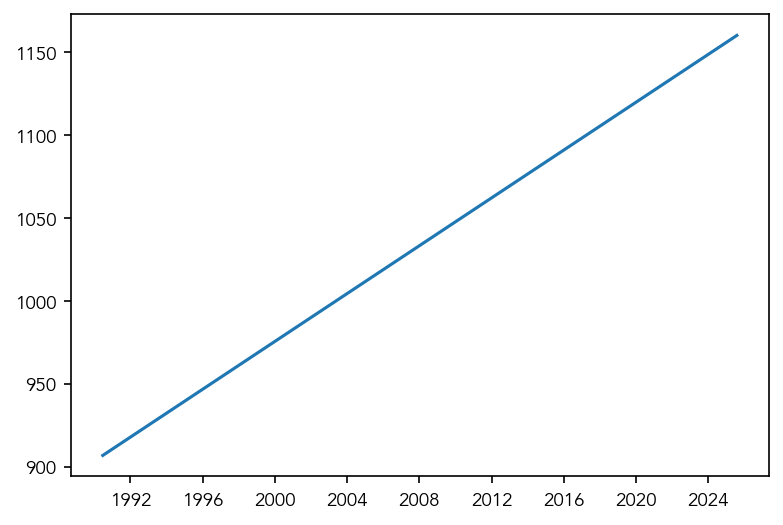

In [304]:
plt.plot(ntr_data['time'],ntr_data['trend'])

In [305]:
column_order

['time',
 'ntr',
 'sea_level',
 'sea_level_detrended',
 'tide',
 'Rank Tide',
 'Trend',
 'Nodal Amp',
 'Nodal Mod',
 'Perigean',
 'Decadal',
 'Interannual',
 'Seasonal',
 'Subannual',
 'Monthly',
 'Weekly',
 'Storms & HF']

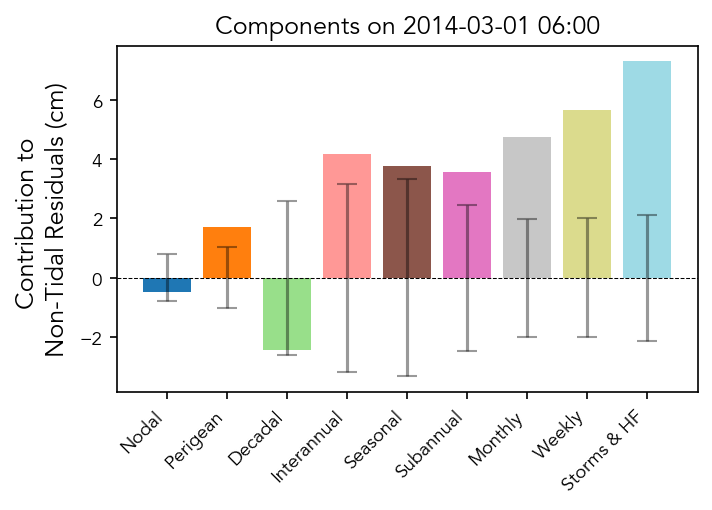

In [306]:
# make separate plot for comparison of event size vs climatology

idx = 1

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]


# Extract the components
components = column_order[6:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
components.remove('Trend')
# components.remove('NTR Trend')
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
bar_width = 0.2
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='Standard Deviation')

ax.set_xticks(x_positions)

# replace 'Nodal Amp' with 'Nodal' in the x-ticks
components = [comp.replace('Nodal Amp', 'Nodal') for comp in components]
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

In [307]:
# data_on_date.iloc[:,6:]
# get sum of columns starting with 'decadal'
data_on_date.iloc[:, 6:].sum(axis=1).values[0]

data_on_date

time         ntr  sea_level  sea_level_detrended  \
207705 2014-03-01 06:00:00  230.066246     2113.0          1035.218191   

              tide  Rank Tide        Trend  Nodal Amp  Nodal Mod   Perigean  \
207705  805.151945      235.0  1077.781809  -4.738191 -16.293875  17.277444   

          Decadal  Interannual   Seasonal  Subannual    Monthly     Weekly  \
207705 -24.457535    41.789734  37.628758  35.801248  47.346141  56.660392   

        Storms & HF  
207705    72.926265

In [308]:
ntr_components = data_on_date.drop(['time','sea_level','sea_level_detrended','tide','ntr','Nodal Amp','Trend','Nodal Mod'], axis=1).sum()
ntr_components

Rank Tide      235.000000
Perigean        17.277444
Decadal        -24.457535
Interannual     41.789734
Seasonal        37.628758
Subannual       35.801248
Monthly         47.346141
Weekly          56.660392
Storms & HF     72.926265
dtype: float64

In [309]:
data_on_date.iloc[:, 8:]

Nodal Mod   Perigean    Decadal  Interannual   Seasonal  Subannual  \
207705 -16.293875  17.277444 -24.457535    41.789734  37.628758  35.801248   

          Monthly     Weekly  Storms & HF  
207705  47.346141  56.660392    72.926265

In [310]:
# sum components
ntr_sum = data_on_date.iloc[:, 9:].sum(axis=1).values[0]
ntr_sum

np.float64(284.97244815216084)

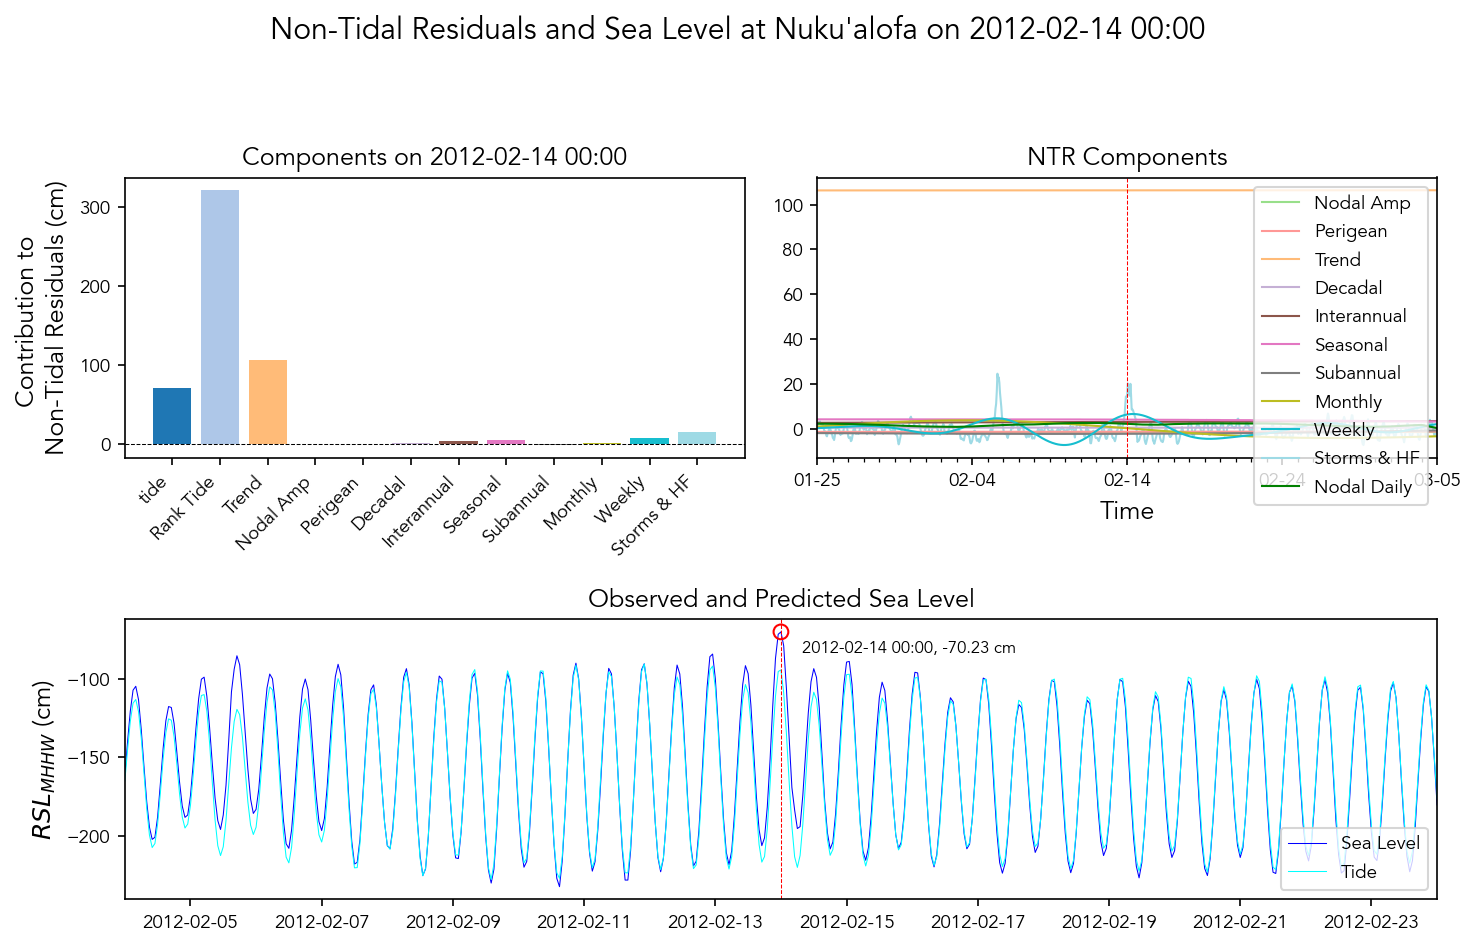

In [311]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

idx = 9

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
ax = axes[0, 0]  # First row, first column
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.set_xticks(x_positions)
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Resize subplot width
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # Shrink width to 75%

### --- TOP RIGHT PLOT: NTR & Weekly Trends --- ###
ax = axes[0, 1]  # First row, second column

# Filter data to ±10 days around `event_date`
plusTime = pd.Timedelta('20d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot NTR and Weekly trends
# ax.plot(data_on_date.index, 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
for col in data_on_date.columns:
    #only do for columns that aren't tide or sea level
    if col not in ['sea_level','sea_level_detrended','tide','NTR','ntr','Storms & HF','Nodal Mod','Rank Tide']:
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1)
    if col == 'Storms & HF': #put on the bottom
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1,zorder=0)

nodal_daily = data_on_date['Nodal Mod'].resample('D').max()
ax.plot(nodal_daily.index, 0.1*nodal_daily, label='Nodal Daily', color='green', linewidth=1)

ax.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

#ensure x-axis is readable
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('NTR Components')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

### --- BOTTOM PLOT: Sea Level, Tide, and Interannual --- ###
fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])
ax = fig.add_subplot(2, 1, 2)

# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('10d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.1*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Tide', color='cyan', linewidth=0.5)
# ax.plot(data_on_date.index, 0.1*(data_on_date['ntr_withNodal'] - mhhw), label='Interannual', color='orange', linewidth=0.5)
ax.set_ylabel('$RSL_{MHHW}$ (cm)')

# Add legend and vertical line
ax.legend(loc='lower right')

# add circle at the date and height
ax.scatter(event_date, 0.1*(sl_extreme-mhhw), color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{date_str}, {0.1*(sl_extreme-mhhw):.2f} cm', 
             (event_date, 0.1*(sl_extreme-mhhw)), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=8)

ax.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

# Set x-axis limits
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('Observed and Predicted Sea Level')

# add title to entire figure
fig.suptitle('Non-Tidal Residuals and Sea Level at ' + station_name + ' on ' + date_str, y=1.05)

plt.tight_layout()
plt.show()


# save the file to desktop as a png
figName = 'NTR_components_' + station_name + '_' + date_str
glue(figName,fig,display=False)

savepath = Path(output_dir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')

# data_on_date


In [312]:
ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend']]

# make a column for "rank" of the sea level
ntr_filtered_extremes_high['rank'] = ntr_filtered_extremes_high['sea_level'].rank(ascending=False, method='first')
ntr_filtered_extremes_low['rank'] = ntr_filtered_extremes_low['sea_level'].rank(ascending=True, method='first')

ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend','rank']].sort_values(by='rank').head(20)


ntr  sea_level                time        Trend  rank
261238  488.398731     2427.0 2020-04-08 19:00:00  1121.842986   1.0
207705  230.066246     2113.0 2014-03-01 06:00:00  1077.781809   2.0
276466  122.372172     2091.0 2022-01-03 07:00:00  1134.376631   3.0
172307  479.967499     2063.0 2010-02-15 08:00:00  1048.646929   4.0
162705  187.189873     2032.0 2009-01-11 06:00:00  1040.743852   5.0
265834  135.233578     2031.0 2020-10-17 07:00:00  1125.625796   6.0
267250   81.597930     2018.0 2020-12-15 07:00:00  1126.791257   7.0
286402   59.752792     2013.0 2023-02-21 07:00:00  1142.554612   8.0
285036   71.888397     2007.0 2022-12-26 09:00:00  1141.430304   9.0
189795  242.466748     2005.0 2012-02-14 00:00:00  1063.040702  10.0
294923   43.879238     2005.0 2024-02-11 08:00:00  1149.567955  11.0
259276  194.514175     2002.0 2020-01-18 01:00:00  1120.228131  12.0
275745   61.767502     2002.0 2021-12-04 06:00:00  1133.783200  13.0
191111  113.966552     1999.0 2012-04-08 20:00:00  1064.123857  14.0
285707   17.547392     1999.0 2023-01-23 08:00:00  1141.982581  15.0
300947   57.996897     1993.0 2024-10-19 08:00:00  1154.526102  16.0
240682   69.976324     1992.0 2017-12-04 07:00:00  1104.924047  17.0
295606   67.357602     1989.0 2024-03-10 19:00:00  1150.130108  18.0
216959   58.894169     1988.0 2015-03-21 20:00:00  1085.398459  19.0
296997   83.690194     1984.0 2024-05-07 18:00:00  1151.274993  20.0

In [313]:
# make timeseries figure

idx = 5

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]

date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_event = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

print(f'Event on {date_str} with sea level {sl_extreme:.2f} cm')

idx = 2

sl_extreme2 = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date2 = ntr_filtered_extremes_high['time'].values[idx]

date_str2 = pd.to_datetime(event_date2).strftime('%Y-%m-%d %H:%M')
data_on_event2 = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date2]

print(f'Event on {date_str2} with sea level {sl_extreme2:.2f} cm')



Event on 2020-10-17 07:00 with sea level 2031.00 cm
Event on 2022-01-03 07:00 with sea level 2091.00 cm


In [314]:
# from tseries_functions import process_trend_with_nan
# trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)
# trend_mag_rsl, trend_rate_rsl

In [315]:
# #plot tide and predicted sea level
# fig, ax = plt.subplots(figsize=(12, 6))
# # Filter data to ±10 days around `event_date`
# plusTime = pd.Timedelta('1000d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_event = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
# data_on_event.set_index('time', inplace=True)
# # Plot sea level, tide, and interannual trend
# ax.plot(data_on_event.index, 0.1*(data_on_event['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
# ax.plot(data_on_event.index, 0.1*(data_on_event['tide']+data_on_event['sea_level']-data_on_event['sea_level_detrended']-mhhw), label='Tide', color='cyan', linewidth=0.5)

In [316]:
ntr_data['trend'].idxmax()

307802

In [317]:
#find top tide value in ntr data
top_tide_index = ntr_data['tide'].idxmax() 

top_tide_value = 0.1*(ntr_data['tide'][top_tide_index]+ ntr_data['trend'][top_tide_index] - mhhw)

top_tide_time = ntr_data['tide'].idxmax()

print(f'Top tide value: {top_tide_value:.2f} cm on {top_tide_time}')

Top tide value: -88.50 cm on 48970


In [318]:
# # rank the tide values (show top 5)
# # set time as index for ntr_data
# ntr_data.set_index('time', inplace=True)

# top_tide_values = ntr_data['tide'].nlargest(5)
# print('Top 5 tide values:')
# for i, (time, value) in enumerate(top_tide_values.items()):
#     print(f'{i+1}. {time}: {0.1*(value - mhhw + msl):.2f} cm')

In [319]:
column_order

['time',
 'ntr',
 'sea_level',
 'sea_level_detrended',
 'tide',
 'Rank Tide',
 'Trend',
 'Nodal Amp',
 'Nodal Mod',
 'Perigean',
 'Decadal',
 'Interannual',
 'Seasonal',
 'Subannual',
 'Monthly',
 'Weekly',
 'Storms & HF']

In [320]:
# x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component

# plt.bar(x_positionsTide+0.4, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, label='Tide Components')


In [321]:
def adjust_axFormat(ax):
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)

In [322]:
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[0:5] + tab10_colors[6:] 
colors # Exclude the 5th color (orange) and use the rest

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

In [323]:
data_on_event

time         ntr  sea_level  sea_level_detrended  \
265834 2020-10-17 07:00:00  135.233578     2031.0           905.374204   

              tide  Rank Tide        Trend  Nodal Amp  Nodal Mod   Perigean  \
265834  770.140626      765.0  1125.625796  10.392279   0.763553 -11.975975   

         Decadal  Interannual   Seasonal  Subannual    Monthly     Weekly  \
265834  1.489176    16.118283 -26.274996    5.63917  20.726689  31.374637   

        Storms & HF  rank  
265834    59.885623   6.0

In [324]:
data_on_event['sea_level']-data_on_event['tide']-data_on_event['ntr']-data_on_event['Trend']

265834    0.0
dtype: float64

In [325]:
# data_on_event['ntr']-data_on_event[componentsNTR].sum(axis=1)

In [326]:
data_on_date

ntr  sea_level  sea_level_detrended        tide  \
time                                                                         
2012-02-04 00:00:00  36.217661     1093.0            30.156834   -6.060827   
2012-02-04 01:00:00  51.592835     1307.0           244.156011  192.563175   
2012-02-04 02:00:00  64.343251     1501.0           438.155188  373.811937   
2012-02-04 03:00:00  81.927976     1634.0           571.154364  489.226389   
2012-02-04 04:00:00  84.071162     1659.0           596.153541  512.082379   
...                        ...        ...                  ...         ...   
2012-02-23 20:00:00 -11.284947     1657.0           593.765054  605.050002   
2012-02-23 21:00:00  -6.333930     1625.0           561.764231  568.098161   
2012-02-23 22:00:00   1.636392     1460.0           396.763408  395.127016   
2012-02-23 23:00:00 -14.422406     1193.0           129.762585  144.184991   
2012-02-24 00:00:00 -40.110874      904.0          -159.238238 -119.127364   

                     Nodal Amp  Nodal Mod   Perigean        Trend   Decadal  \
time                                                                          
2012-02-04 00:00:00 -10.381110  -3.075483 -10.549558  1062.843166  8.186403   
2012-02-04 01:00:00 -10.380912  -7.012669 -10.548251  1062.843989  8.185645   
2012-02-04 02:00:00 -10.380714  -8.945093 -10.546943  1062.844812  8.184887   
2012-02-04 03:00:00 -10.380517  -8.243726 -10.545634  1062.845636  8.184130   
2012-02-04 04:00:00 -10.380319  -5.630555 -10.544326  1062.846459  8.183372   
...                        ...        ...        ...          ...       ...   
2012-02-23 20:00:00 -10.285297 -13.809888  -9.892276  1063.234946  7.813944   
2012-02-23 21:00:00 -10.285092  -1.486551  -9.890823  1063.235769  7.813137   
2012-02-23 22:00:00 -10.284887  10.157143  -9.889369  1063.236592  7.812329   
2012-02-23 23:00:00 -10.284682  18.554425  -9.887915  1063.237415  7.811521   
2012-02-24 00:00:00 -10.284477  23.549844  -9.886461  1063.238238  7.810713   

                     Interannual   Seasonal  Subannual    Monthly     Weekly  \
time                                                                           
2012-02-04 00:00:00    31.614446  45.288015 -19.179832  40.748272  23.873877   
2012-02-04 01:00:00    31.622683  45.288015 -19.188115  40.733960  24.950589   
2012-02-04 02:00:00    31.630921  45.288015 -19.196347  40.718279  26.020145   
2012-02-04 03:00:00    31.639159  45.288015 -19.204530  40.701227  27.081285   
2012-02-04 04:00:00    31.647397  45.288015 -19.212663  40.682806  28.132744   
...                          ...        ...        ...        ...        ...   
2012-02-23 20:00:00    35.535691  40.469309 -14.747761 -35.070255  -8.229873   
2012-02-23 21:00:00    35.543818  40.469309 -14.716493 -35.144532  -7.687789   
2012-02-23 22:00:00    35.551944  40.469309 -14.685125 -35.217839  -7.138226   
2012-02-23 23:00:00    35.560069  40.469309 -14.653656 -35.290177  -6.581303   
2012-02-24 00:00:00    35.568193  40.035709 -14.622087 -35.361548  -6.017160   

                     Storms & HF  Rank Tide  
time                                         
2012-02-04 00:00:00   -49.025505   154932.0  
2012-02-04 01:00:00   -34.711928   114923.0  
2012-02-04 02:00:00   -23.014634    68126.0  
2012-02-04 03:00:00    -6.473295    33543.0  
2012-02-04 04:00:00    -5.362493    27877.0  
...                          ...        ...  
2012-02-23 20:00:00     3.413307    11471.0  
2012-02-23 21:00:00     7.857930    16766.0  
2012-02-23 22:00:00    15.313309    61279.0  
2012-02-23 23:00:00    -1.268858   125051.0  
2012-02-24 00:00:00   -27.488984   177325.0  

[481 rows x 16 columns]

In [327]:
# plusTime = pd.Timedelta('1000d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
# data_on_date.set_index('time', inplace=True)

# plt.plot(data_on_date.index, data_on_date['ntr'] , label='NTR', color='black', linewidth=0.5)
# plt.plot(data_on_date.index, data_on_date[componentsNTR].sum(axis=1)+data_on_date['NTR Trend'], label='Summed NTR', color='green', linewidth=1)

In [328]:
sla_tg

<xarray.Dataset> Size: 276kB
Dimensions:       (station_id: 2, time: 11488)
Coordinates:
    latitude      (station_id) float32 8B ...
  * time          (time) datetime64[ns] 92kB 1993-01-01 ... 2024-06-14
    longitude     (station_id) float32 8B ...
  * station_id    (station_id) int64 16B 25 38
Data variables:
    sla           (station_id, time) float64 184kB ...
    station_name  (station_id) <U10 80B ...
    lat_str       (station_id) <U8 64B ...
    lon_str       (station_id) <U9 72B ...
Attributes:
    original_data_source:  CMEMS L4 SSH 0.125deg
    title:                 DT merged all satellites Global Ocean Gridded SSAL...
    source_file:           /Users/juliafiedler/Documents/SL_Hawaii_data/data/...

Processing xarray DataArray (vectorized polyfit, time in years)...
Processing xarray DataArray (vectorized polyfit, time in years)...


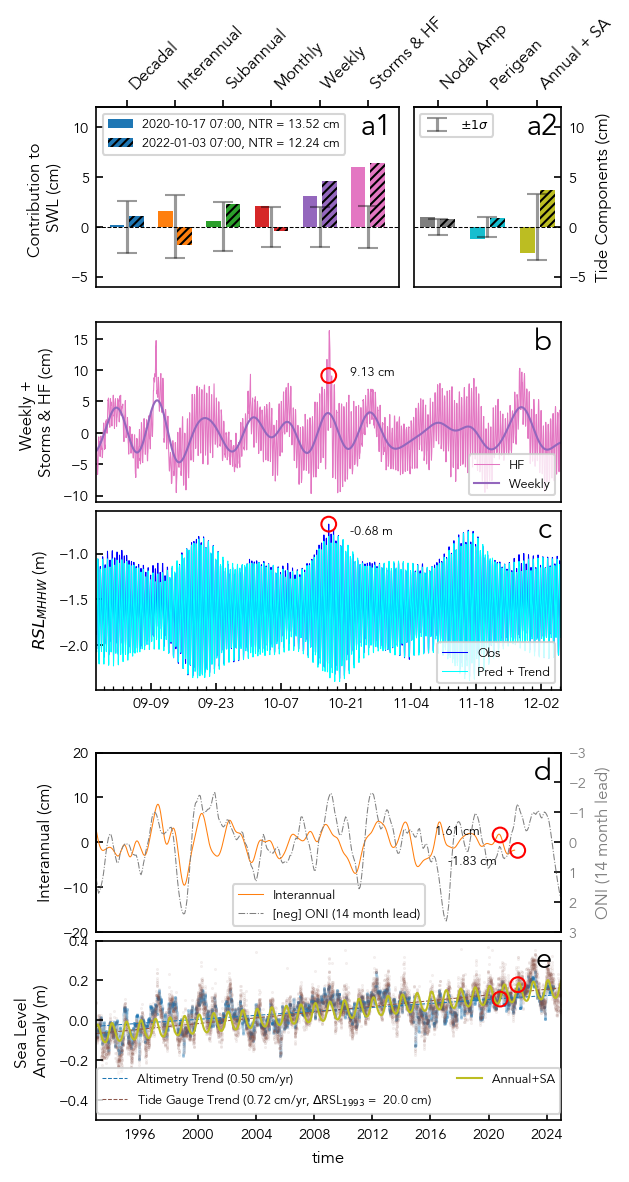

In [333]:
# make timeseries figure
import matplotlib.pyplot as plt
# add mdates for x-axis formatting
import matplotlib.dates as mdates

componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']
componentsTide = ['Nodal Amp', 'Perigean', 'Seasonal']

fig, axes = plt.subplots(5, 1, figsize=(4, 9))


component_values = data_on_event[componentsNTR].values.flatten()
component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 0.1*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 0.1*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.3
ax = axes[0]  # First row, first column

ax.bar(
    x_positions-0.2,
    0.1*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{0.1 * data_on_event["ntr"].values[0]:.2f} cm'
)
ax.bar(
    x_positions+0.2,
    0.1*component_values2,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    hatch=hatches,
    label=date_str2 + ', NTR = ' + f'{0.1 * data_on_event2["ntr"].values[0]:.2f} cm'
)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 12])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide-0.2, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,12])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=6, frameon=True, loc='upper left')


# Move x-tick labels to the top
ax2.set_xticklabels([])
ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(x_positionsTide)
componentsTide = [comp.replace('Nodal Mod', 'Nodal') for comp in componentsTide]
componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.98, 0.97, 'a2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
    
ax.text(0.98, 0.97, 'a1', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
        
# 

### --- ADD NEXT PLOT --- ###
ax = axes[1]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Storms & HF']+ data_on_date['Weekly']), label='HF', linewidth=0.5, color=component_colors['Storms & HF'])
ax.plot(data_on_date.index, 0.1*(data_on_date['Weekly']), label='Weekly', linewidth=1, color=component_colors['Weekly'])

ax.legend(loc='lower right', fontsize=6)

sl_value = 0.1*(data_on_event['Storms & HF']+ data_on_event['Weekly']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.1*(data_on_event2['Storms & HF']+ data_on_event2['Weekly']).values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, 0), 
             ha='left', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} cm',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(10, 0), 
             ha='left', 
             fontsize=6)

ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('Weekly + \nStorms & HF (cm)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 4TH PLOT: Sea Level, Tide, and Interannual --- ###
ax = axes[2]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.001*(data_on_date['sea_level'] - mhhw), label='Obs', color='blue', linewidth=0.5)
# ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Pred', color='cyan', linewidth=0.5)
ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['Trend']-mhhw), label='Pred + Trend', color='cyan', linewidth=0.5)
# ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+ntr_filtered['Trend'].mean()-mhhw), label='Pred', color='cyan', linewidth=0.5)


sl_value = 0.001*(data_on_event['sea_level'] - mhhw).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.001*(data_on_event2['sea_level'] - mhhw).values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} m',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -5), 
             ha='left', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} m',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(10, -5), 
             ha='left', 
             fontsize=6)


ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('$RSL_{MHHW}$ (m)')

ax.legend(loc='lower right', fontsize=6)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 5TH PLOT: Inter-Annual --- ###
ax = axes[3]  # First row, second column
# Filter data to ±100 days around `event_date`

# plusTime = pd.Timedelta('8000d')
timespan = pd.date_range(start=pd.to_datetime('1993-01-01'), end=event_date + pd.Timedelta('365d'), freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Interannual']), label='Interannual', color=component_colors['Interannual'], linewidth=0.5)
ax.set_ylabel('Interannual (cm)')
# ax.set_ylim([-7.75,5.25])

# add lagged ONI
# Create a second y-axis for ONI
ax2 = ax.twinx()
onicolor = 'gray'
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label='[neg] ' + ylabel, color=onicolor, linewidth=0.5,linestyle='-.')

ax2.set_ylabel(ylabel, color=onicolor, fontsize=6)
ax2.tick_params(axis='y', labelcolor=onicolor)
ax2.set_ylim([-3, 3])
ax.set_ylim([-20, 20])

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis


sl_value = 0.1*data_on_event['Interannual'].values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.1*data_on_event2['Interannual'].values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(-10, 0), 
             ha='right', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} cm',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(-10, -7), 
             ha='right', 
             fontsize=6)

# ax.set_xlim([timespan[0], timespan[-1]])
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower center', fontsize=6)

adjust_axFormat(ax2)

### --- 2ND PLOT: SLR --- ###
# load altimetry data for tide gauge location
# get the record id of the station
ax = axes[4]  # First row, first column
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_pacific.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_pacific.nc')

#align alimetry data to tide gauge station (adjust mean to match tide gauge)
rsl_daily['rsl_anomaly'].loc[dict(station_id=station)] = (
    rsl_daily['rsl_anomaly'].sel(station_id=station)
    - rsl_daily['rsl_anomaly'].sel(station_id=station).mean()
    + sla_tg['sla'].sel(station_id=station).mean()
)
palette = plt.cm.tab10.colors

from tseries_functions import process_trend_with_nan


trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)

# plot altimetry data
sla_tg['sla'].sel(station_id=station).plot.scatter(ax = ax, x='time', color=palette[0], alpha=0.1, s=0.2)
trend_line_asl.sel(station_id=station).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(station_id=station):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--', linewidth=0.5)
rsl_daily.rsl_anomaly.sel(station_id=station).plot.scatter(ax = ax, x='time', color=palette[5], alpha=0.1, s=0.2)


# Ensure ntr_data has a DatetimeIndex for resampling
if not isinstance(ntr_data.index, pd.DatetimeIndex):
    ntr_data = ntr_data.set_index('time')

seasonal_cycle_daily = 0.001*ntr_data['seasonal_cycle'].resample('d').mean()
# Align the trend_line_rsl to the same daily index if needed
trend_line_rsl_daily = trend_line_rsl.sel(station_id=station).to_pandas().reindex(seasonal_cycle_daily.index, method='nearest')


# Find the nearest index for event_date in the Series
nearest_idx = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date)], method='nearest')[0]
nearest_time = seasonal_cycle_daily.index[nearest_idx]

idx_2000 = trend_line_rsl_daily.index.get_loc(pd.to_datetime('2000-01-01'))
idx_1993 = trend_line_rsl_daily.index.get_loc(pd.to_datetime('1993-01-01'))


sl_value = seasonal_cycle_daily.loc[nearest_time] 
trend_value = trend_line_rsl_daily.loc[nearest_time]
trend_value_2000 = trend_value - trend_line_rsl_daily.iloc[idx_2000]  # Adjust trend value to 2000 baseline
trend_value_1993 = trend_value - trend_line_rsl_daily.iloc[idx_1993]  # Adjust trend value to 1993 baseline
trend_line_rsl.sel(station_id=station).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(station_id=station):.2f} cm/yr, $\Delta$RSL$_{{1993}}$ =  {100*trend_value_1993:.1f} cm)', 
                                                      color=palette[5], linestyle='--', linewidth=0.5)

ax.plot(seasonal_cycle_daily.index, seasonal_cycle_daily + trend_line_rsl_daily, label='Annual+SA', color=component_colorsTide['Seasonal'], linewidth=1)

ax.scatter(event_date, sl_value+trend_value, color='red', s=50, zorder=5, facecolors='none')


nearest_idx2 = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date2)], method='nearest')[0]
nearest_time2 = seasonal_cycle_daily.index[nearest_idx2]
sl_value2 = seasonal_cycle_daily.loc[nearest_time2] 
trend_value2 = trend_line_rsl_daily.loc[nearest_time2]
ax.scatter(event_date2, sl_value2+trend_value2, color='red', s=50, zorder=5, facecolors='none')

# set x-axis limits from 1993 to 2025
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])
ax.set_ylim([-0.5, 0.4])
ax.legend(loc='lower center',ncol = 2, fontsize=6)
# title = f'{rsl_daily.station_name.sel(station_id=station).values}'
ax.set_title('')
ax.set_ylabel('Sea Level \nAnomaly (m)') 


def adjust_axFormat(ax):
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)

# set all ylabels to be the same size
for ax in axes:
    adjust_axFormat(ax)

# add a,b,c,d labels to each plot
for i, ax in enumerate(axes):
    if i>0:
        ax.text(0.98, 0.97, chr(97 + i), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')


#remove bottom x-tick labels from axes[1]
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes2pos = axes[2].get_position
#move axes[2] up a smidge
axes[2].set_position([axes2pos().x0, axes2pos().y0 + 0.02, axes2pos().width, axes2pos().height])


#remove bottom x-tick labels from axes[1]
axes[3].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes4pos = axes[4].get_position
#move axes[2] up a smidge
axes[4].set_position([axes4pos().x0, axes4pos().y0 + 0.02, axes4pos().width, axes4pos().height])


# save figure
figName = 'Components_timeseries_' + station_name 
savepath = Path(output_dir, figName + 'new.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')
# save the figure to the output directory




In [330]:
sla_tg.sel(station_id=station).sla

<xarray.DataArray 'sla' (time: 11488)> Size: 92kB
[11488 values with dtype=float64]
Coordinates:
    latitude    float32 4B ...
  * time        (time) datetime64[ns] 92kB 1993-01-01 1993-01-02 ... 2024-06-14
    longitude   float32 4B ...
    station_id  int64 8B 38
Attributes:
    long_name:      Sea level anomaly
    units:          m
    standard_name:  sea_surface_height_above_sea_level

In [331]:
data_on_event

time         ntr  sea_level  sea_level_detrended  \
265834 2020-10-17 07:00:00  135.233578     2031.0           905.374204   

              tide  Rank Tide        Trend  Nodal Amp  Nodal Mod   Perigean  \
265834  770.140626      765.0  1125.625796  10.392279   0.763553 -11.975975   

         Decadal  Interannual   Seasonal  Subannual    Monthly     Weekly  \
265834  1.489176    16.118283 -26.274996    5.63917  20.726689  31.374637   

        Storms & HF  rank  
265834    59.885623   6.0

KeyError: "'record_id' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'station_id': 2, 'time': 11688})"

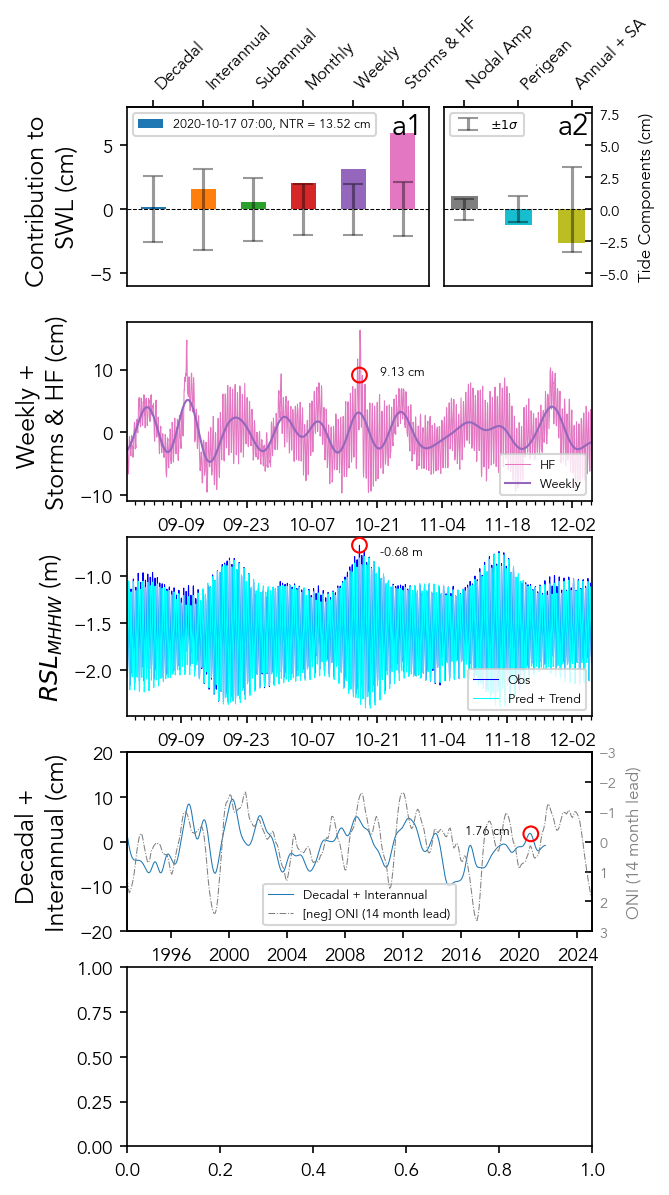

In [332]:
# make timeseries figure
import matplotlib.pyplot as plt
# add mdates for x-axis formatting
import matplotlib.dates as mdates

componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']
componentsTide = ['Nodal Amp', 'Perigean', 'Seasonal']

fig, axes = plt.subplots(5, 1, figsize=(4, 9))


component_values = data_on_event[componentsNTR].values.flatten()
# component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 0.1*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 0.1*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.5
ax = axes[0]  # First row, first column

ax.bar(
    x_positions,
    0.1*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{0.1 * data_on_event["ntr"].values[0]:.2f} cm'
)
# ax.bar(
#     x_positions+0.2,
#     0.1*component_values2,
#     alpha=1,
#     color=[component_colors[c] for c in componentsNTR],
#     width=bar_width,
#     hatch=hatches,
#     label=date_str2 + ', NTR = ' + f'{0.1 * data_on_event2["ntr"].values[0]:.2f} cm'
# )
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 8])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
# ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,8])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=6, frameon=True, loc='upper left')


# Move x-tick labels to the top
ax2.set_xticklabels([])
ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(x_positionsTide)
componentsTide = [comp.replace('Nodal Mod', 'Nodal') for comp in componentsTide]
componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.98, 0.97, 'a2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
    
ax.text(0.98, 0.97, 'a1', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
        
# 

### --- ADD NEXT PLOT --- ###
ax = axes[1]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Storms & HF']+ data_on_date['Weekly']), label='HF', linewidth=0.5, color=component_colors['Storms & HF'])
ax.plot(data_on_date.index, 0.1*(data_on_date['Weekly']), label='Weekly', linewidth=1, color=component_colors['Weekly'])

ax.legend(loc='lower right', fontsize=6)

sl_value = 0.1*(data_on_event['Storms & HF']+ data_on_event['Weekly']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

# sl_value2 = 0.1*(data_on_event2['Storms & HF']+ data_on_event2['Weekly']).values[0]
# ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, 0), 
             ha='left', 
             fontsize=6)

# ax.annotate(f'{sl_value2:.2f} cm',
#              (event_date2, sl_value2), 
#              textcoords='offset points', 
#              xytext=(10, 0), 
#              ha='left', 
#              fontsize=6)

ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('Weekly + \nStorms & HF (cm)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 4TH PLOT: Sea Level, Tide, and Interannual --- ###
ax = axes[2]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.001*(data_on_date['sea_level'] - mhhw), label='Obs', color='blue', linewidth=0.5)
# ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Pred', color='cyan', linewidth=0.5)
ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['Trend']-mhhw), label='Pred + Trend', color='cyan', linewidth=0.5)
# ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+ntr_filtered['Trend'].mean()-mhhw), label='Pred', color='cyan', linewidth=0.5)


sl_value = 0.001*(data_on_event['sea_level'] - mhhw).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

# sl_value2 = 0.001*(data_on_event2['sea_level'] - mhhw).values[0]
# ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} m',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -5), 
             ha='left', 
             fontsize=6)

# ax.annotate(f'{sl_value2:.2f} m',
#              (event_date2, sl_value2), 
#              textcoords='offset points', 
#              xytext=(10, -5), 
#              ha='left', 
#              fontsize=6)


ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('$RSL_{MHHW}$ (m)')

ax.legend(loc='lower right', fontsize=6)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 5TH PLOT: Inter-Annual --- ###
ax = axes[3]  # First row, second column
# Filter data to ±100 days around `event_date`

# plusTime = pd.Timedelta('8000d')
timespan = pd.date_range(start=pd.to_datetime('1993-01-01'), end=event_date + pd.Timedelta('365d'), freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
# ax.plot(data_on_date.index, 0.1*(data_on_date['Decadal']), label='Decadal', color=component_colors['Decadal'], linewidth=0.5)

ax.plot(data_on_date.index, 0.1*(data_on_date['Decadal']+data_on_date['Interannual']), label='Decadal + Interannual', color=component_colors['Decadal'], linewidth=0.5)
ax.set_ylabel('Decadal + \nInterannual (cm)')
# ax.set_ylim([-7.75,5.25])

# add lagged ONI
# Create a second y-axis for ONI
ax2 = ax.twinx()
onicolor = 'gray'
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label='[neg] ' + ylabel, color=onicolor, linewidth=0.5,linestyle='-.')

ax2.set_ylabel(ylabel, color=onicolor, fontsize=6)
ax2.tick_params(axis='y', labelcolor=onicolor)
ax2.set_ylim([-3, 3])
ax.set_ylim([-20, 20])

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis


sl_value = 0.1*(data_on_event['Decadal']+ data_on_event['Interannual']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

# sl_value2 = 0.1*data_on_event2['Interannual'].values[0]
# ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value-0.1*data_on_event['Decadal'].values[0]), 
             textcoords='offset points', 
             xytext=(-10, 0), 
             ha='right', 
             fontsize=6)

# ax.annotate(f'{sl_value2:.2f} cm',
#              (event_date2, sl_value2), 
#              textcoords='offset points', 
#              xytext=(-10, -7), 
#              ha='right', 
#              fontsize=6)

# ax.set_xlim([timespan[0], timespan[-1]])
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower center', fontsize=6)

adjust_axFormat(ax2)

### --- 2ND PLOT: SLR --- ###
# load altimetry data for tide gauge location
# get the record id of the station
ax = axes[4]  # First row, first column
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_pacific.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_pacific.nc')

#align alimetry data to tide gauge station (adjust mean to match tide gauge)
rsl_daily['rsl_anomaly'].loc[dict(station_id=station)] = (
    rsl_daily['rsl_anomaly'].sel(record_id=station)
    - rsl_daily['rsl_anomaly'].sel(record_id=station).mean()
    + sla_tg['sla'].sel(record_id=station).mean()
)
palette = plt.cm.tab10.colors

from tseries_functions import process_trend_with_nan


trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)

# plot altimetry data
sla_tg['sla'].sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[0], alpha=0.1, s=0.2)
trend_line_asl.sel(record_id=station).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--', linewidth=0.5)
rsl_daily.rsl_anomaly.sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[5], alpha=0.1, s=0.2)


# Ensure ntr_data has a DatetimeIndex for resampling
if not isinstance(ntr_data.index, pd.DatetimeIndex):
    ntr_data = ntr_data.set_index('time')

seasonal_cycle_daily = 0.001*ntr_data['seasonal_cycle'].resample('d').mean()
# Align the trend_line_rsl to the same daily index if needed
trend_line_rsl_daily = trend_line_rsl.sel(record_id=station).to_pandas().reindex(seasonal_cycle_daily.index, method='nearest')


# Find the nearest index for event_date in the Series
nearest_idx = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date)], method='nearest')[0]
nearest_time = seasonal_cycle_daily.index[nearest_idx]

idx_2000 = trend_line_rsl_daily.index.get_loc(pd.to_datetime('2000-01-01'))


sl_value = seasonal_cycle_daily.loc[nearest_time] 
trend_value = trend_line_rsl_daily.loc[nearest_time]
trend_value_2000 = trend_value - trend_line_rsl_daily.iloc[idx_2000]  # Adjust trend value to 2000 baseline
trend_line_rsl.sel(record_id=station).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(record_id=station):.2f} cm/yr, $\Delta$RSL$_{{2000}}$ =  {100*trend_value_2000:.1f} cm)', 
                                                      color=palette[5], linestyle='--', linewidth=0.5)

ax.plot(seasonal_cycle_daily.index, seasonal_cycle_daily + trend_line_rsl_daily, label='Annual+SA', color=component_colorsTide['Seasonal'], linewidth=1)

ax.scatter(event_date, sl_value+trend_value, color='red', s=50, zorder=5, facecolors='none')


# nearest_idx2 = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date2)], method='nearest')[0]
# nearest_time2 = seasonal_cycle_daily.index[nearest_idx2]
# sl_value2 = seasonal_cycle_daily.loc[nearest_time2] 
# trend_value2 = trend_line_rsl_daily.loc[nearest_time2]
# ax.scatter(event_date2, sl_value2+trend_value2, color='red', s=50, zorder=5, facecolors='none')

# set x-axis limits from 1993 to 2025
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])
ax.set_ylim([-0.5, 0.4])
ax.legend(loc='lower center',ncol = 2, fontsize=6)
# title = f'{rsl_daily.station_name.sel(record_id=station).values}'
ax.set_title('')
ax.set_ylabel('Sea Level \nAnomaly (m)') 


def adjust_axFormat(ax):
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)

# set all ylabels to be the same size
for ax in axes:
    adjust_axFormat(ax)

# add a,b,c,d labels to each plot
for i, ax in enumerate(axes):
    if i>0:
        ax.text(0.98, 0.97, chr(97 + i), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')


#remove bottom x-tick labels from axes[1]
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes2pos = axes[2].get_position
#move axes[2] up a smidge
axes[2].set_position([axes2pos().x0, axes2pos().y0 + 0.02, axes2pos().width, axes2pos().height])


#remove bottom x-tick labels from axes[1]
axes[3].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes4pos = axes[4].get_position
#move axes[2] up a smidge
axes[4].set_position([axes4pos().x0, axes4pos().y0 + 0.02, axes4pos().width, axes4pos().height])


# save figure
figName = 'Components_timeseries_' + station_name 
savepath = Path(output_dir, figName + 'new.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')
# save the figure to the output directory




In [ ]:
# put both events into same dataframe
# data_on_event_combined = pd.concat([data_on_event, data_on_event2], axis=0)
data_on_event_combined = data_on_event.copy()
# data_on_event_combined['time'] = pd.to_datetime(data_on_event_combined
# make time the index
data_on_event_combined.set_index('time', inplace=True)
#flip so index is columns, and columns are index


data_on_event_combined = data_on_event_combined.T

# add rank in terms of sea level for epoch

# save as csv
# add column for notes for each component
# make a dictionary of notes for each component
notes = {
    'Decadal': '>7-year variations, calculated from non-tidal residuals',
    'Interannual': '1-7 year variations, calculated from non-tidal residuals',
    'Subannual': '3 month - 1 year variations, calculated from non-tidal residuals',
    'Monthly': '1-3 month variations, calculated from non-tidal residuals',
    'Weekly': '1 week -1 month variations, calculated from non-tidal residuals',
    'Storms & HF': '<1 week variations, calculated from non-tidal residuals',
    'Nodal Mod': 'Difference between predicted tides with and without nodal corrections (hourly signal)',
    'Nodal Amp': 'Upper envelope Nodal amplitude, 18.61 year sinusoid fitted to 99.9th percentile of Nodal Mod (hourly signal)',
    'Perigean': '4.425 and 8.85 year cycles, calculated from full tide model (including seasonal and nodal)',
    'Seasonal': 'Annual and Semiannual cycles, constructed with utide SA and SSA components',
    'ntr': 'Non-tidal residuals, calculated as sea level minus the predicted tide (including seasonal and nodal) and linear trend',
    'sea_level': 'Observed sea level, relative to STND',
    'sea_level_detrended': 'Observed sea level, relative to STND, linearly detrended',
    'tide': 'Predicted tide, including seasonal and nodal, using epoch 2002-2020',
    'Trend': 'Linear trend value of sea level, relative to STND, using epoch 2002-2020',
    'Rank Tide': 'Rank of tide value, relative to STND, using epoch 2002-2020',
    'rank': 'Rank of sea level event (all time highest hourly sea level). Events occuring within 3 days of each other are counted as the same event.',
}

units = {
    'Decadal': 'mm',
    'Interannual': 'mm',
    'Subannual': 'mm',
    'Monthly': 'mm',
    'Weekly': 'mm',
    'Storms & HF': 'mm',
    'Nodal Mod': 'mm',
    'Nodal Amp': 'mm',
    'Perigean': 'mm',
    'Seasonal': 'mm',
    'ntr': 'mm',
    'sea_level': 'mm',
    'sea_level_detrended': 'mm',
    'tide': 'mm',
    'Trend': 'mm',
    'Rank Tide': '',
    'rank': '',
}


# add notes to the dataframe
data_on_event_combined['Description'] = data_on_event_combined.index.map(notes)
data_on_event_combined['units'] = data_on_event_combined.index.map(units)

# rename the rows to be capitalized
data_on_event_combined.index = data_on_event_combined.index.str.replace('_', ' ')
data_on_event_combined.index = data_on_event_combined.index.str.title()

#rename Ntr to NTR
data_on_event_combined.rename(index={'Ntr': 'NTR'}, inplace=True)
data_on_event_combined.rename(index={'Storms & Hf':'Storms & HF'}, inplace=True)

# save the dataframe to a csv file
output_csv_path = Path(output_dir, f'Components_summary_{station_name}New.csv')
data_on_event_combined.to_csv(output_csv_path)

In [ ]:
output_dir

In [ ]:
ntr_filtered_extremes_high

In [ ]:
idx = 10

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_event = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
components.remove('Rank Tide')
component_values = data_on_event[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(5, 1, figsize=(4, 9))



# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Amp')
components.remove('Trend')
components.remove('Rank Tide')
# replace 'Nodal Amp' with 'Nodal' in the x-ticks

component_values = data_on_event[components].values.flatten()

x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:7]
component_colors = {comp: colors[i % 10] for i, comp in enumerate(component_order)}


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.2
ax = axes[0]  # First row, first column
components = [comp.replace('Nodal Mod', 'Nodal') for comp in components]
ax.bar(x_positions, 0.1*component_values, alpha=1, color = [component_colors[c] for c in components])
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.legend(loc='lower right', fontsize=6, frameon=True)
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(components, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)



# ### --- 3RD PLOT: NTR & Weekly Trends --- ###
# ax = axes[2]  # First row, second column
# # Filter data to ±10 days around `event_date`
# plusTime = pd.Timedelta('20d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()

# ax.plot(data_on_date['time'], 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
# ax.set_xlim([timespan[0], timespan[-1]])

# # add event date in red circle
# ax.scatter(event_date, 0.1*data_on_event['ntr'], color='red', s=50, zorder=5, facecolors='none')
# ntr_value = data_on_event["ntr"].values[0]
# ax.annotate(f'{date_str}, {0.1*ntr_value:.2f} cm',
#              (event_date, 0.1*ntr_value), 
#              textcoords='offset points', 
#              xytext=(10, -10), 
#              ha='left', 
#              fontsize=6)
# ax.set_ylabel('NTR (cm)')

# # make the x-axis readable, use only month day

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- ADD NEXT PLOT --- ###
ax = axes[1]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Storms & HF']+ data_on_date['Weekly']), label='HF', linewidth=0.5, color=component_colors['Storms & HF'])
ax.plot(data_on_date.index, 0.1*(data_on_date['Weekly']), label='Weekly', linewidth=0.5, color=component_colors['Weekly'])

ax.legend(loc='lower right', fontsize=6)

sl_value = 0.1*(data_on_event['Storms & HF']+ data_on_event['Weekly']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=6)

ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('Weekly + \nStorms & HF (cm)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 4TH PLOT: Sea Level, Tide, and Interannual --- ###
ax = axes[2]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.001*(data_on_date['sea_level'] - mhhw), label='Obs', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Pred', color='cyan', linewidth=0.5)


sl_value = 0.001*(data_on_event['sea_level'] - mhhw).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{sl_value:.2f} m',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=6)
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('$RSL_{MHHW}$ (m)')

ax.legend(loc='lower right', fontsize=6)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 5TH PLOT: Inter-Annual --- ###
ax = axes[3]  # First row, second column
# Filter data to ±100 days around `event_date`

plusTime = pd.Timedelta('8000d')
timespan = pd.date_range(start=event_date -plusTime, end=pd.to_datetime('2025-01-01'), freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Interannual']+data_on_date['Decadal']), label='Interannual', color=component_colors['Interannual'], linewidth=0.5)
ax.set_ylabel('Interannual +\nDecadal (cm)')

# add lagged ONI
# Create a second y-axis for ONI
ax2 = ax.twinx()
onicolor = 'darkolivegreen'
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label='-' + ylabel, color=onicolor, linewidth=0.5,linestyle='-.')

ax2.set_ylabel(ylabel, color=onicolor, fontsize=6)
ax2.tick_params(axis='y', labelcolor=onicolor)

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis


sl_value = 0.1*(data_on_event['Interannual']+data_on_event['Decadal']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')


ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(-10, 0), 
             ha='right', 
             fontsize=6)
ax.set_xlim([timespan[0], timespan[-1]])

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower left', fontsize=6)

### --- 2ND PLOT: SLR --- ###
# load altimetry data for tide gauge location
# get the record id of the station
ax = axes[4]  # First row, first column
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_pacific.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_pacific.nc')
palette = sns.color_palette()

from tseries_functions import process_trend_with_nan


trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)

# plot altimetry data
sla_tg['sla'].sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[0], alpha=0.1, s=0.2)
trend_line_asl.sel(record_id=station).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--', linewidth=0.5)
rsl_daily.rsl_anomaly.sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[1], alpha=0.1, s=0.2)
trend_line_rsl.sel(record_id=station).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[1], linestyle='--', linewidth=0.5)

# Ensure ntr_data has a DatetimeIndex for resampling
if not isinstance(ntr_data.index, pd.DatetimeIndex):
    ntr_data = ntr_data.set_index('time')

seasonal_cycle_daily = 0.001*ntr_data['seasonal_cycle'].resample('d').mean()
# Align the trend_line_rsl to the same daily index if needed
trend_line_rsl_daily = trend_line_rsl.sel(record_id=station).to_pandas().reindex(seasonal_cycle_daily.index, method='nearest')

ax.plot(seasonal_cycle_daily.index, seasonal_cycle_daily + trend_line_rsl_daily, label='Seasonal', color=component_colors['Seasonal'], linewidth=0.5)

# Find the nearest index for event_date in the Series
nearest_idx = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date)], method='nearest')[0]
nearest_time = seasonal_cycle_daily.index[nearest_idx]
sl_value = seasonal_cycle_daily.loc[nearest_time] 
trend_value = trend_line_rsl_daily.loc[nearest_time]

ax.scatter(event_date, sl_value+trend_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{100*sl_value:.2f} cm',
             (event_date, sl_value+trend_value), 
             textcoords='offset points', 
             xytext=(5, 10), 
             ha='right', 
             fontsize=6)

# set x-axis limits from 1993 to 2025
ax.set_xlim([event_date -plusTime, pd.to_datetime('2025-01-01')])
ax.set_ylim([-0.3, 0.4])
ax.legend(loc='lower center',ncol = 2, fontsize=6)
# title = f'{rsl_daily.station_name.sel(record_id=station).values}'
ax.set_title('')
ax.set_ylabel('Sea Level \nAnomaly (m)') 


# set all ylabels to be the same size
for ax in axes:
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)
    #make minor ticks inner

# add a,b,c,d labels to each plot
for i, ax in enumerate(axes):
    ax.text(0.05, 0.95, chr(97 + i), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')



In [ ]:
station

In [ ]:
plt.plot(data_on_date.index, data_on_date['sea_level_detrended']-data_on_date['tide'], label='NTR', color='blue', linewidth=0.5)
plt.plot(data_on_date.index, data_on_date['ntr']-5, label='ntr', color='orange', linewidth=0.5)
# plt.plot(data_on_date.index, data_on_date['Nodal Mod'], label='Nodal', color='green', linewidth=0.5)

# add a line for the date
plt.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

# a line at the date - 6 hours
# plt.axvline(event_date - pd.Timedelta('7h'), color='red', linestyle='--', linewidth=0.5)


In [ ]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [ ]:
ntr_filtered_extremes_low

In [ ]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [ ]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level','sea_level_detrended','Trend','Nodal Amp'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

In [ ]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


In [ ]:
1993-mhhw

In [ ]:
data_on_event

In [ ]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
data_on_event2

In [ ]:
# save data_on_event to csv
output_path = output_dir / f'SL_NTR_components_{station_name}_data_on_event2.csv'
data_on_event2.to_csv(output_path)

In [ ]:
# make timeseries figure
import matplotlib.pyplot as plt
# add mdates for x-axis formatting
import matplotlib.dates as mdates

station_id  = station

componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']
componentsTide = ['Nodal Amp', 'Perigean', 'Seasonal']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))


component_values = data_on_event[componentsNTR].values.flatten()
component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 0.1*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 0.1*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.3

ax.bar(
    x_positions-0.2,
    0.1*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{0.1*data_on_event["ntr"].values[0]:.2f} cm , Height: ' + f"{0.001*(data_on_event['sea_level'].values[0] - mhhw):.2f} m"
)
ax.bar(
    x_positions+0.2,
    0.1*component_values2,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    hatch=hatches,
    label=date_str2 + ', NTR = ' + f'{0.1 * data_on_event2["ntr"].values[0]:.2f} cm, Height: ' + f"{0.001*(data_on_event2['sea_level'].values[0] - mhhw):.2f} m"
)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 10])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide-0.2, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,10])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=6, frameon=True, loc='upper left')


# Move x-tick labels to the top
ax2.set_xticklabels([])
ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(x_positionsTide)
componentsTide = [comp.replace('Nodal Amp', 'Nodal') for comp in componentsTide]
componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.98, 0.97, 'a2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
    
ax.text(0.98, 0.97, 'a1', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
        
# add station info on the bottom xlabel
ax.set_xlabel(station_name + ' (' + str(station_id) + ')')

# save the file to desktop as a png
figName = 'NTR_components_' + station_name + '_' + date_str
glue(figName,fig,display=False)

savepath = Path(output_dir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')

## Make a Table


In [ ]:
# Now we'll make a nice readable table of the highest and lowest sea level events and their components
# It should be ntr_filtered_extremes_high with the extremes_high_relative_to_std in parentheses

# make a copy of ntr_filtered_extremes_high
extremes_table = ntr_filtered_extremes_high.copy()

# make it relative to mhhw
extremes_table['sea_level'] = extremes_table['sea_level'] - mhhw
extremes_table['tide'] = extremes_table['tide'] - mhhw + extremes_table['Trend']

# print out only :.2f 
extremes_table = extremes_table.round(2)

#rank according to sea level
extremes_table = extremes_table.sort_values(by='sea_level', ascending=False)
extremes_table




In [ ]:
# check if extremes table everything from interdecadal to storms & hf added equals ntr
extremes_table['sum'] = extremes_table['Decadal'] + extremes_table['Interannual'] + extremes_table['Seasonal'] + extremes_table['Intraannual'] + extremes_table['Weekly'] + extremes_table['Storms & HF']
#print both columns
extremes_table[['ntr','sum']]

In [ ]:
# make time the index
# extremes_table = extremes_table.set_index('time')

#change everything except time column to cm
extremes_table.iloc[:,1:] = extremes_table.iloc[:,1:]*0.1

#format time to be more readable
# extremes_table['time'] = extremes_table['time'].dt.strftime('%Y-%m-%d %H:%M')

# round to 2 decimal places
extremes_table = extremes_table.round(1)

extremes_table
# remove sum column
extremes_table = extremes_table.drop(columns='sum')

# put sea_level in first column
extremes_table = extremes_table[['time','sea_level','tide','ntr','Nodal Mod','Decadal','Interannual','Seasonal','Intraannual','Weekly','Storms & HF']]


In [ ]:
extremes_table

In [ ]:
clear formatted_table

In [ ]:
# now combine extremes_table with extremes_high_relative_to_std
extremes_table_relative = extremes_table.copy()
extremes_table_relative = extremes_table_relative.set_index('time')
std_table = extremes_high_relative_to_std.copy()
std_table = std_table.set_index('time')

#sort both on sea_level
extremes_table_relative = extremes_table_relative.sort_values(by='sea_level', ascending=False)
std_table = std_table.sort_values(by='sea_level', ascending=False)

extremes_table_relative

# Find common columns
common_columns = extremes_table_relative.columns.intersection(std_table.columns)

# Select only common columns from both tables
extremes_common = extremes_table_relative[common_columns]
std_common = std_table[common_columns]

# Rename std columns to make them distinct
std_common = std_common.rename(columns={col: f"{col}_std" for col in common_columns})

# Interleave columns (merge column-by-column)
interleaved_columns = sum(zip(extremes_common.columns, std_common.columns), ())  # Creates interleaved column order

# Combine the tables, ensuring interleaved order
formatted_table = pd.concat([extremes_common, std_common], axis=1)[list(interleaved_columns)]

# Add back 'sea_level' and 'ntr' at the front
formatted_table = pd.concat([extremes_table_relative[['sea_level', 'ntr']], formatted_table], axis=1)

#drop sea_level_std column
formatted_table = formatted_table.drop(columns=['sea_level_std','sea_level'])

# add 'sea level' column back in front
formatted_table.insert(0, 'sea_level', extremes_table_relative['sea_level'])

# format all to 1 decimal place
formatted_table = formatted_table.round(1)

formatted_table


In [ ]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html, style, loc

# make time a column again
formatted_table_time = formatted_table.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')

#change 'Storms & HF_std' to 'Storms_std'
formatted_table_time = formatted_table_time.rename(columns={'Storms & HF_std': 'Storms_std'})

# ntr_columns = ['Interdecadal','Interdecadal_std',
#                'Decadal','Decadal_std',
#                'Interannual','Interannual_std',
#                'Seasonal','Seasonal_std',
#                'Intraannual','Intraannual_std',
#                'Weekly','Weekly_std',
#                'Storms & HF','Storms_std']

ntr_columns = ['Decadal','Decadal_std',
               'Interannual','Interannual_std',
               'Seasonal','Seasonal_std',
               'Intraannual','Intraannual_std',
               'Weekly','Weekly_std',
               'Storms & HF','Storms_std']

# ntr_columns = ['Nodal','Nodal_std']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "30px" for col in ntr_columns}
#add time to col_width_dict
col_width_dict['time'] = "120px"
col_width_dict['Nodal Amp'] = "20px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="12px")
    .cols_width(cases={"time" : "150px"})
        .cols_label(
        time=html(''),
        ntr=html('NTR'),
        sea_level=html('Sea Level'),
        tide_std=html('(σ̂)'),
        Decadal_std=html('(σ̂)'),
        Interannual_std=html('(σ̂)'),
        Interannual=html('Inter-\nannual'),
        Seasonal_std=html('(σ̂)'),
        Intraannual_std=html('(σ̂)'),
        Intraannual=html('Intra-\nannual'),
        Weekly_std=html('(σ̂)'),
        Storms_std=html('(σ̂)'),
        **{"Nodal Mod_std": html('(σ̂)')},  # Use quotes for column names with spaces
         **{"Nodal Amp_std": html('(σ̂)')},  # Use quotes for column names with spaces
        tide=html('Tide'))
        # .tab_spanner(
            # label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. The (σ̂) represents the magnitude of each component relative to its standard deviation.')
        # .tab_source_note(
            # source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        # .fmt_number(
            # columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)

)


In [ ]:
formatted_table_time

This table is trying to be the best at both worlds but is probably too complicated. A simpler version:

In [ ]:
# make time a column again
formatted_table_time = extremes_table_relative.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')


ntr_columns = ['Interdecadal',
               'Decadal',
               'Interannual',
               'Seasonal',
               'Intraannual',
               'Weekly',
               'Storms & HF']

ntr_columns = ['Decadal',
               'Interannual',
               'Seasonal',
               'Intraannual',
               'Weekly',
               'Storms & HF']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "5%" for col in ntr_columns}
#add time to col_width_dict
# col_width_dict['time'] = "120px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

timeframes_str = "; ".join([f"{k}: {v}" for k, v in timeframes.items()])

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="13px")
    .cols_width(cases={"time": "150px"})
    .cols_label(
        time = html(''),
        ntr=html('NTR'), sea_level=html('Sea Level'), Interdecadal = html('Inter-\ndecadal'),
        Interannual=html('Inter-\nannual'),Intraannual=html('Intra-\nannual'),
        tide=html('Tide'))
        .tab_spanner(
            label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. '
            'The Nodal component shown here is included in the Tide component, representing the nodal modulation of the tide at the given hour. '
            'The timescales of the NTR components are as follows: ' + timeframes_str + '.')
            
        .tab_source_note(
            source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        .fmt_number(
            columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)
)

## Make a map

In [ ]:
# let's turn our our bar chart into a pie chart
# we'll use what we used previously to get the std of each component
# ntr_cumsum_stds
# ntr_var = ntr_filtered['ntr'].var()

# ntr_component_vars['covariance'] = ntr_var - sum_ntr_var

# get the difference between each successive component
ntr_cumsum_diff = ntr_cumsum_stds.diff()

ntr_cumsum_diff['Interdecadal'] = ntr_cumsum_stds['Interdecadal']

#reverse the order of the components
# ntr_cumsum_stds = ntr_cumsum_stds[::-1]
# ntr_component_vars = ntr_component_vars[::-1]

# # make a pie chart, ignoring co-variance for now because omg
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(ntr_cumsum_diff, labels=ntr_cumsum_diff.index, startangle=140)
center_circle = plt.Circle((0, 0), 0.5, fc='white')  # Creates a white hole
ax.add_patch(center_circle)



In [ ]:
# make a locations dictionary, with stations: (lat, lon)
# from ds
stations = ds['station_name'].values
lons = ds['lon'].values
lats = ds['lat'].values
station_id = ds['record_id'].values

locations = {station: (lon,lat) for station, lat, lon in zip(stations, lats, lons)}
station_ids = {station: id for station, id in zip(stations, station_id)}

# make pie_data dictionary
ntr_component_stds_subset = ntr_component_stds.copy()
ntr_component_stds_subset = ntr_component_stds_subset.drop(['sea_level', 'tide'])
pie_data = {station: ntr_component_stds_subset for station in stations}


locations
station_ids

In [ ]:
# make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
pie_data = {}
ntr_mag = {}
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
        # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    if 'ntr' in station_data.index:
        ntr_mag[station] = station_data.loc['ntr'].values[0]
        station_data = station_data.drop(index='ntr')
    # print(station_data)
    # ntr_mag[station] = station_data['ntr']
    station_data = station_data.drop(index=['sea_level','tide'])
    # remove 'sea_level' and 'tide' columns
    pie_data[station] = station_data.squeeze()



In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

crs = ccrs.PlateCarree(central_longitude=180)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': crs})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='lightgrey')

# cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024.nc')

xlims = [ds['lon'].min()-5, ds['lon'].max()+5]
ylims = [ds['lat'].min()-5, ds['lat'].max()+5]
xlims_360 = [x + 360 if x < 0 else x for x in xlims]

ax.set_extent([xlims_360[0], xlims_360[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())

def plot_pie_inset(data, lon, lat, station, ax, width, alpha=1):
    # Convert lat/lon to map display coordinates
    x, y = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())[:2]
    y = y + 1 
    x = x + 0.5
    pie_ax = inset_axes(ax, width=width, height=width, loc=10, 
                        bbox_to_anchor=(x, y), bbox_transform=ax.transData, borderpad=0)
    pie_ax.set_facecolor('none')  # Fully transparent background

    wedges, texts, autotexts = pie_ax.pie(data, autopct='',startangle=140, 
                                          wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 0.5})
    
    # pie_ax.pie(data, startangle=140)  # Draw pie chart
    pie_ax.set_xticks([])
    pie_ax.set_yticks([])
    pie_ax.set_frame_on(False)  # Hide frame
    # add title
    # pie_ax.set_title(station, fontsize=8)

for station, data in pie_data.items():
    lon, lat = locations[station]
    # if data is all zeros, skip
    if np.all(data == 0):
        continue
    width = 0.5*(ntr_mag[station]/max(ntr_mag.values()))

    plot_pie_inset(data, lon, lat, station,ax, width=width)

ax.scatter(lons, lats, color='black', s=5, label='Station', transform=ccrs.PlateCarree())


#add grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks(),crs=crs)
#make all labels tiny
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


# Will need to fix longitude labels!!
ax.set_title('Non-Tidal Residual Component Beachballs by Station')


In [ ]:
# # make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
# pie_data = {}

# make a dataframe of the ntr_component_stds, with each station as a column
ntr_component_stds_df = pd.DataFrame(columns=stations)
# ntr_component_stds_df = ntr_component_stds_df.append(ntr_component_stds, ignore_index=True)
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
#         # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    ntr_component_stds_df[station] = station_data.squeeze()

#replace nans with 0
ntr_component_stds_df = ntr_component_stds_df.fillna(0).infer_objects(copy=False)
#change 'tide' to 'Tide' in index
ntr_component_stds_df = ntr_component_stds_df.rename(index={'tide':'Tide'})

In [ ]:
ntr_component_stds_df

In [ ]:
#Repeat the map exercise using only the amplitudes of each component at each station, will just be a scatter plot
from maps import plot_thin_map_hawaii, get_stationinfo

fig, ax = plt.subplots(3, 3, figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ntr_component_names = ntr_component_stds_df.index
#remove sea level and ntr
ntr_component_names = ntr_component_names.drop(['sea_level','ntr'])

colors = plt.cm.tab20(np.linspace(0, 1, len(ntr_component_names)))

for i,ax in enumerate(ax.flat):
    ax,gl = plot_thin_map_hawaii(ax) ## THIN MAP HAWAII IS YOUR FIRST MISTAKE, THIS WON'T WORK FOR TONGA FRIEND

    # crs = ccrs.PlateCarree(central_longitude=180)

    xlims = [ds['lon'].min()-50, ds['lon'].max()+50]
    ylims = [ds['lat'].min()-5, ds['lat'].max()+5]

    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    ntrmag = ntr_component_stds_df.loc[ntr_component_names[i]]
    ntrmagNorm = ntrmag/ntrmag.max()
    ax.scatter(lons, lats, s=200*ntrmagNorm, c = ntrmagNorm, alpha=0.8,
                transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='black')
    
    # add label for station name in upper right
    ax.text(0.95, 0.8, ntr_component_names[i], fontsize=14, ha='right', transform=ax.transAxes)
    
    #remove gl labels from interior plots
    if i % 3 != 0:
        gl.right_labels = False
        gl.left_labels = False

    if i < 6:
        gl.top_labels = False
        gl.bottom_labels = False

    if i%3 == 0:
        gl.right_labels = False

    if i>=6:
        gl.top_labels = False

plt.tight_layout()
#adjust 
# add title
fig.suptitle('Relative Amplitude of Tide and NTR Components by Station')

# suptitle should be higher
plt.subplots_adjust(top=0.95)



In [ ]:
# make ntr components figure for all gauges
# Create figure
# fig, ax = plt.subplots(figsize=(6, 6))

# make empty dataframe ntr_component_stds_df
ntr_component_stds_df = pd.DataFrame(columns=ds['station_name'].values)

# get list of all ntr_component_stds in data folder, and combine them into a single dataframe
for station, id in zip(ds['station_name'].values, ds['record_id'].values):
    # read in the ntr_component_stds file
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    # add to the dataframe
    ntr_component_stds_df[station] = station_data.squeeze()
# ntr_component_stds = pd.read_csv(Path(data_dir, f'ntr_data/ntr_{station:03d}_component_stds.csv'), index_col=0)


# ntr_component_vars_cumsum = ntr_component_vars.cumsum()/ntr_component_vars_sum * ntr_var #normalize to the variance of the ntr (not filtered)
# # Plot stacked bars
# bottom = 0
# for i in range(len(ntr_component_waveheight.index)-1, -1, -1):
#     ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))

# # ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# # Labels and title
# ax.set_ylabel('Height (cm)')
# ax.set_title('Non-Tidal Residual Components by Frequency \n' + station_name)
# ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# # plt.xticks(rotation=45)
# # plt.grid(axis='y', linestyle='--', alpha=0.7)

# # no box
# for spine in ax.spines.values():
#     spine.set_visible(False)

# figName = 'NTR_components_stds' + station_name
# glue('NTR_components_stds',fig,display=False)

ntr_component_stds_df